# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. We'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project include many more features than might be needed and has not been pre-cleaned.

In [46]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats 
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# settings these options helps with viewing more of the data at once
pd.set_option('max.columns',400)
pd.set_option('max.rows',400)

## Part 0: Get to Know the Data

There are four data files associated with this project:
- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).

### Load the data and explore
The Excel files are also viewed in MS Excel

In [3]:
# load data dictionary
print('Loading data, started at', pd.Timestamp.now())
df_attributes = pd.read_excel("data/DIAS Information Levels - Attributes 2017.xlsx", skiprows=1, usecols="C:D")
df_attributes_values = pd.read_excel("data/DIAS Attributes - Values 2017.xlsx", skiprows=1, usecols="B:E")
print('Loading data, completed at', pd.Timestamp.now())

Loading data, started at 2022-03-30 19:45:15.098710
Loading data, completed at 2022-03-30 19:45:16.474504


In [4]:
# load in the population and customer data
print('Loading data, started at', pd.Timestamp.now())
population = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
print('Loading data, completed at', pd.Timestamp.now())

Loading data, started at 2022-03-30 19:45:16.489488


C:\Users\Thomas\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading data, completed at 2022-03-30 19:45:50.786216


In [5]:
# load in the train data
print('Loading data, started at', pd.Timestamp.now())
train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print('Loading data completed at', pd.Timestamp.now())

Loading data, started at 2022-03-30 19:45:50.816185
Loading data completed at 2022-03-30 19:45:52.139817


In [6]:
# check for info and nas and column names
# comment or uncomment dataframes of interest
print('##### Attributes Excel File Info #####')
print(df_attributes.info())
df_attributes.isna().sum()/len(df_attributes)

print('##### Attributes Values Excel File Info #####')
print(df_attributes_values.info())
df_attributes_values.isna().sum()/len(df_attributes_values)
# print(df_attributes_values.groupby([]))

print('##### Population Data Info #####')
print(population.info())
print('Percent Na')
print(np.round((population.isna().sum()/len(population)).mul(100).sort_values(ascending=False),2).head())

print('##### Customers Data Info #####')
print(customers.info())
print('Percent Na')
print(np.round((customers.isna().sum()/len(customers)).mul(100).sort_values(ascending=False),2).head())

print('##### Train Data Info #####')
print(train.info())
print('Percent Na')
print(np.round((train.isna().sum()/len(train)).mul(100).sort_values(ascending=False),2).head())

customers.head()


##### Attributes Excel File Info #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    313 non-null    object
 1   Description  313 non-null    object
dtypes: object(2)
memory usage: 5.0+ KB
None
##### Attributes Values Excel File Info #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None
##### Population Data Info #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

There's a LOT of cleaning that needs doing. Viewing the xlsx file in Excel shows many attributes don't have clear enough descriptions.<br>
First, tidy up the data dictionary by filling nans and updating some of the attribute names to match the column names seen in the customer and population dataframeNext, tidy up the data dictionary by filling nans and updating some of the attribute names to match the column names seen in the customer and population dataframe

In [7]:
def clean_data_dictionary(data_dictionary):
    """
    Clean the data dictionary so that it aligns with the core data and can be used for looking up the descriptions of attributes meanings of values
    """
    # Nans are created after reading the dictionary Excel file because of empty cells and merged cells. These will need to be forward filled.
    # Some cells in the Excel worksheet within the Description column are somewhat separate from the main description and sit below the main description in a separate row.
    # These will be removed before forward filling
    lst_descrs_to_remove = ['(each German CAMEO code belongs to one international code)',' - on grid level -','the environmental sustainability is the dominating movement in the youth of these consumers', "'- classified number of inhabitants"]
    for i in lst_descrs_to_remove:
        data_dictionary['Description'].loc[data_dictionary['Description']==i] = np.nan
    data_dictionary = data_dictionary.fillna(method='ffill')

    # A few attributes in the data dictionary need renaming to match the table column names
    data_dictionary['Attribute'] = data_dictionary['Attribute'].str.replace('CAMEO_DEUINTL_2015','CAMEO_INTL_2015')
    data_dictionary['Attribute'] = data_dictionary['Attribute'].str.replace('D19_KK_KUNDENTYP','KK_KUNDENTYP')
    data_dictionary['Attribute'] = data_dictionary['Attribute'].str.replace('D19_BUCH_RZ','D19_BUCH_CD')
    data_dictionary['Attribute'] = data_dictionary['Attribute'].str.replace('SOHO_FLAG','SOHO_KZ')
    data_dictionary['Attribute'] = data_dictionary['Attribute'].str.replace('_RZ','')

    # After using Google Translate on the variables, there's an opportunity to add an attribute to the data dictionary.
    # Add the 'number of children' attribute to the data dictionary
    df_extra_attributes = pd.DataFrame({
        'Attribute':['ANZ_KINDER'],
        'Description':['number of children'],
        'Value':['…'],
        'Meaning':['numeric value']
    })

    data_dictionary = pd.concat([data_dictionary, df_extra_attributes])
    data_dictionary.index = list(range(len(data_dictionary)))

    # Separate the rows in the dictionary which have multiple values in 'Value' field (separated using a ',') into new rows so each row has its own Value
    for i in range(len(data_dictionary)):
        if ',' in str(data_dictionary.iloc[i,2]):
            for val in data_dictionary.iloc[i,2].split(', '):
                newrow = data_dictionary.iloc[i,:]
                newrow['Value'] = val
                data_dictionary = data_dictionary.append(newrow,ignore_index=True)
    
    data_dictionary = data_dictionary[~data_dictionary['Value'].str.contains(', ',na=False)]
    
    # a few gramatical corrections in description
    data_dictionary['Description'] = data_dictionary['Description'].str.replace('descirbing', 'describing')
    
    return data_dictionary

In [8]:
transform_active = True
if transform_active:
    print('Cleaning data dictionary, started at', pd.Timestamp.now())
    df_attributes_values = clean_data_dictionary(df_attributes_values)
    print('Completed at', pd.Timestamp.now())

Cleaning data dictionary, started at 2022-03-30 19:45:53.830269


c:\dev\.conda\envs\udacity_training\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


Completed at 2022-03-30 19:45:54.492895


The next checks which attribute names are missing in each of the dataframes before and after cleaning the data dictionary

In [9]:
# columns in customers df not found in the dictionary
# attributes in dictionary not found in customers df
attrs_missing_customers = [i for i in df_attributes_values['Attribute'].unique() if i not in customers.columns]
cust_cols_missing_attr = [col for col in customers.columns if col not in df_attributes_values['Attribute'].values]

# attributes in dictionary not found in population df
attrs_missing_population = [i for i in df_attributes_values['Attribute'].unique() if i not in population.columns]
population_cols_missing_attr = [col for col in population.columns if col not in df_attributes_values['Attribute'].values]

# attributes in dictionary not found in train df
attrs_missing_population = [i for i in df_attributes_values['Attribute'].unique() if i not in train.columns]
train_cols_missing_attr = [col for col in train.columns if col not in df_attributes_values['Attribute'].values]
# print(cols_missing_attr)
# print(attrs_missing_customers)
# print(attrs_missing_population)
print('columns in the population data missing from the data dictionary:',len(population_cols_missing_attr)) # 56 
print('columns in the customers data missing from the data dictionary:',len(cust_cols_missing_attr)) # 59. The difference of 3 is the bonus columns of customer labels
print('columns in the train data missing from the data dictionary:', len(train_cols_missing_attr)) # 57 makes sense as it has 1 column with outcome of mailout
# these columns were reviewed to understand them and check if any column names should be amended or new entries added to the dictionary.

columns in the population data missing from the data dictionary: 56
columns in the customers data missing from the data dictionary: 59
columns in the train data missing from the data dictionary: 57


Reduce the customers, population and train dataframe to the columns found in the cleaned dictionary and see the shape.<br>
Keep the three columns showing bonus information on customers, and the RESPONSE column in the train dataframe

In [10]:
lst_extra_cust_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
lst_extra_train_cols = ['RESPONSE']

transform_active = True
if transform_active:
    print('Reducing data to columns with descriptions, started at', pd.Timestamp.now())
    # locating columns in data dictionary and customers dataframe
    attrbs_to_keep = [attrb for attrb in set(df_attributes_values['Attribute'].values) if attrb in customers.columns and attrb in population.columns and attrb in train.columns]
    print('number of attributes to keep:',len(attrbs_to_keep))
    customers = customers[attrbs_to_keep + lst_extra_cust_cols]
    population = population[attrbs_to_keep]
    train = train[attrbs_to_keep + lst_extra_train_cols]
    print('Completed at', pd.Timestamp.now())
print(customers.shape)
print(population.shape)
print(train.shape)

Reducing data to columns with descriptions, started at 2022-03-30 19:45:54.602781
number of attributes to keep: 310
Completed at 2022-03-30 19:45:55.534539
(191652, 313)
(891221, 310)
(42962, 311)


In [11]:
# Check distribution of nans across rows
print('CUSTOMERS: % of rows grouped to missing column count')
print(((customers.isna().sum(axis=1)).value_counts().sort_index(ascending=False)/customers.shape[0]).mul(100).head(10))
print('POPULATION: % of rows grouped to missing column count')
print(((population.isna().sum(axis=1)).value_counts().sort_index(ascending=False)/population.shape[0]).mul(100).head(10))
print('TRAIN: % of rows grouped to missing column count')
print(((train.isna().sum(axis=1)).value_counts().sort_index(ascending=False)/train.shape[0]).mul(100).head(10))
# This reveals there are some rows with large numbers of NaNs in the columns.

CUSTOMERS: % of rows grouped to missing column count
214     0.002087
212    24.312817
210     0.000522
209     0.019828
208     0.024002
205     0.002087
204     0.012001
203     0.000522
200     0.013044
199     0.676226
dtype: float64
POPULATION: % of rows grouped to missing column count
214    0.002020
212    8.247000
210    0.000112
209    0.003703
208    0.005386
205    0.015933
204    0.508965
203    0.003815
200    0.019524
199    0.823477
dtype: float64
TRAIN: % of rows grouped to missing column count
212    16.221312
209     0.020949
208     0.020949
205     0.002328
204     0.039570
200     0.034915
199     0.784414
198     0.935711
197     0.041897
190     0.002328
dtype: float64


In [12]:
# Calculate percentage nan and check if a field is numeric or categoric.
customers_pct_na = (customers.isna().sum()/len(customers)).rename('customers_pct_na')
population_pct_na = (population.isna().sum()/len(population)).rename('population_pct_na')
train_pct_na = (train.isna().sum()/len(train)).rename('train_pct_na')
pct_na = pd.concat([customers_pct_na,population_pct_na, train_pct_na],axis=1,sort=True)
pct_na = pct_na.reset_index().rename({'index':'Attribute'},axis=1)

# Join it to the data dictionary to view descriptions
df_info = pd.merge(pct_na,df_attributes_values,on='Attribute',how='left')
df_info['numeric'] = df_info['Value']=='…'

In [13]:
df_info.sort_values(['numeric','customers_pct_na'],ascending=False).head(10)
# this reveals that there are only 8 numeric variables out of over 300. Almost all are categorical.
# These numeric variables would also work well as categorical variables. 
# We'll make all variables categorical for consistency.

,Attribute,customers_pct_na,population_pct_na,train_pct_na,Description,Value,Meaning,numeric
39,ANZ_HH_TITEL,0.271899,0.108848,0.191937,number of academic title holder in building,…,numeric value (typically coded from 1-10),True
1206,KBA13_ANZAHL_PKW,0.267574,0.118714,0.185327,number of cars in the PLZ8,…,numeric value,True
38,ANZ_HAUSHALTE_AKTIV,0.260509,0.104517,0.181020,number of households in the building,…,numeric value (typically coded from 1-10),True
2026,MIN_GEBAEUDEJAHR,0.260509,0.104517,0.181020,year the building was first mentioned in our d...,…,numeric value,True
40,ANZ_KINDER,0.243128,0.082470,0.162213,number of children,…,numeric value,True
41,ANZ_PERSONEN,0.243128,0.082470,0.162213,number of adult persons in the household,…,numeric value (typically coded from 1-3),True
42,ANZ_TITEL,0.243128,0.082470,0.162213,number of professional title holder in household,…,numeric value (typically coded from 1-10),True
706,GEBURTSJAHR,0.000000,0.000000,0.000000,year of birth,…,numeric value,True
1918,KK_KUNDENTYP,0.584064,0.655967,0.589265,consumption movement in the last 12 months,-1,unknown,False
1919,KK_KUNDENTYP,0.584064,0.655967,0.589265,consumption movement in the last 12 months,1,regular customer,False


#### Clean the data: fill nas with a value for 'unknown' and update data dictionary where needed

In [14]:
def clean_core_data(customers, population, train, data_dictionary):
    """
    Fill na values with any existing 'unknown' Value or otherwise create a new 'unknown' Value. Update the data dictionary with the new 'unknown'
    Returns the cleaned versions of the core tables and the updated data dictionary
    parameters
        customers: DataFrame
        population: DataFrame
        train: DataFrame
        data_dictionary: DataFrame
    """
    # identify dictionary attributes which have one or more existing values representing 'unknown'
    df_attribs_with_unknown = data_dictionary[data_dictionary['Meaning'].str.lower().str.contains('unknown|no[\w\s]+known')]

    # loop through all the attributes and identify the first value for 'unknown' or create a fresh one
    for attrb in attrbs_to_keep:
        # Locate the first existing 'unknown' key in the data dictionary
        if attrb in df_attribs_with_unknown['Attribute'].values:
            fillval = df_attribs_with_unknown[df_attribs_with_unknown['Attribute']==attrb].iloc[0,2]
        # if none was found, use the default of -1
        else:
            fillval = -1            
            # Since the attribute does not have an 'unknown' value found in the data dictionary, update the data dictionary to include one.
            description = data_dictionary[data_dictionary['Attribute']==attrb].iloc[0,1]
            # create new entries for the data dictionary
            df_new_entry = pd.DataFrame({
                'Attribute':[attrb],
                'Description':[description],
                'Value':[-1],
                'Meaning':['unknown']
            })

            # concatenate the new entry with the data dictionary
            data_dictionary = pd.concat([data_dictionary, df_new_entry])

        # fill the na values in the columns with the respective fill value for 'unknown'
        customers[attrb] = customers[attrb].fillna(fillval)
        population[attrb] = population[attrb].fillna(fillval)
        train[attrb] = train[attrb].fillna(fillval)
    return customers, population, train, data_dictionary

In [15]:
transform_active = True
if transform_active:
    print('Cleaning core data, started at', pd.Timestamp.now())
    customers, population, train, df_attributes_values = clean_core_data(customers, population, train, df_attributes_values)
    print('Completed at', pd.Timestamp.now())    
print(customers.shape)
print(population.shape)
print(train.shape)

Cleaning core data, started at 2022-03-30 19:45:57.563463
Completed at 2022-03-30 19:46:46.938521
(191652, 313)
(891221, 310)
(42962, 311)


#### Define functions for transforming numeric variables in the main dataframes and updating the data dictionary

In [16]:
def convert_int_to_categorical(s, lst_bands, other_val = -1):
    """
    convert a series with numeric values into a series with categorical values
    parameters:
        s: series
        lst_bands: list
        other_val: bool, default -1
            value to use for filling cells not specified in bands (including nans)
    """
    s.astype(str)
    for i in range(len(lst_bands)):
        lower, upper = lst_bands[i]
        s = s.mask((s>=lower) & (s<=upper), i)
    s = s.where(s.isin(list(range(len(lst_bands)))), other_val)
    
    return s

In [17]:
def update_data_dict(df, attribute, description, lst_meanings, lst_values=None, suppress_test=False):
    """
    update the data dictionary with names for categories
    parameters:
        df: dataframe
            dataframe of data dictionary
        attribute: string
            attribute name to add in the data dictionary
        description: string
            description to add in the data dictionary
        lst_meanings: list
            list of meanings for the respective attribute values
        lst_values: list, default None
            list of possible values for the attribute. None means it creates a list.
        supress_test: bool, default False
            option to suppress the test used for checking for duplicates
            
    """
    # adding a check for if the attribute already exists in the dictionary to avoid duplicates
    if not suppress_test:
        assert attribute not in df['Attribute'], 'attribute already exists in dictionary. drop first or use different name'
    
    if lst_values is None:
        lst_values = [-1] + list(range(len(lst_meanings)))

    lst_meanings = ['unknown'] + lst_meanings

    # create new entries for the data dictionary
    df_new_entries = pd.DataFrame({
        'Attribute':[attribute]*len(lst_meanings),
        'Description':[description]*len(lst_meanings),
        'Value':lst_values,
        'Meaning':lst_meanings
    })

    # concatenate with the data dictionary
    df_ddict_updated = pd.concat([df[~(df['Attribute']==attribute)], df_new_entries])
    
    return df_ddict_updated

In [18]:
def transform_core_data(lst_dfs, data_dictionary):
    """
    Go through the main dataframes of customers, population and train to transform the numeric variables to categorical, update the data dictionary and fill nas
    Returns the same list of dataframes and the data dictionary
    parameters
        lst_dfs: list
            list of dataframes - expecting the customers, population and train dataframes
        data_dictionary: DataFrame
    """

    for i in range(len(lst_dfs)):
        # create categorical variable for the numeric attribute 'ANZ_HH_TITEL' to
        lst_bands = [(0,0),(1,1),(2,2),(3,999)]
        lst_dfs[i]['cat_ANZ_HH_TITEL'] = convert_int_to_categorical(lst_dfs[i]['ANZ_HH_TITEL'], lst_bands, other_val = -1)
        lst_meanings = ['0', '1', '2', '3 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_ANZ_HH_TITEL', 'number of holders of an academic title in the building', lst_meanings)

        # create categorical variable for the numeric attribute 'ANZ_HH_TITEL' to
        lst_bands = [(0,0),(1,1),(2,2),(3,3),(4,999)]
        lst_dfs[i]['cat_ANZ_KINDER'] = convert_int_to_categorical(lst_dfs[i]['ANZ_KINDER'], lst_bands, other_val = -1)
        lst_meanings = ['0', '1', '2', '3', '4 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_ANZ_KINDER', 'number of children', lst_meanings)

        # convert numeric data for attribute 'KBA13_ANZAHL_PKW'
        lst_bands = [(0,299),(300,499),(500,699),(700,999),(1000,9999999)]
        lst_dfs[i]['cat_KBA13_ANZAHL_PKW'] = convert_int_to_categorical(lst_dfs[i]['KBA13_ANZAHL_PKW'], lst_bands, other_val = -1)
        lst_meanings = ['0 to 299', '300 to 499', '500 to 699','700 to 999', '1000 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_KBA13_ANZAHL_PKW', 'number of cars in the PLZ8', lst_meanings)

        # convert numeric data for attribute 'ANZ_HAUSHALTE_AKTIV'
        lst_bands = [(0,0),(1,1),(2,2),(3,4),(5,9),(10,19),(20,9999)]
        lst_dfs[i]['cat_ANZ_HAUSHALTE_AKTIV'] = convert_int_to_categorical(lst_dfs[i]['ANZ_HAUSHALTE_AKTIV'], lst_bands, other_val = -1)
        lst_meanings = ['0', '1', '2', '3 to 4', '5 to 9', '10 to 19', '20 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_ANZ_HAUSHALTE_AKTIV', 'number of households known in this building', lst_meanings)

        # convert numeric data for attribute 'ANZ_PERSONEN'
        lst_bands = [(0,0),(1,1),(2,2),(3,4),(5,999)]
        lst_dfs[i]['cat_ANZ_PERSONEN'] = convert_int_to_categorical(lst_dfs[i]['ANZ_PERSONEN'], lst_bands, other_val = -1)
        lst_meanings = ['0', '1', '2', '3 to 4', '5 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_ANZ_PERSONEN', 'number of persons known in this household', lst_meanings)

        # convert numeric data for attribute 'ANZ_TITEL'
        lst_bands = [(0,0),(1,1),(2,99)]
        lst_dfs[i]['cat_ANZ_TITEL'] = convert_int_to_categorical(lst_dfs[i]['ANZ_TITEL'], lst_bands, other_val = -1)
        lst_meanings = ['0', '1', '2 or more']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_ANZ_TITEL', 'number of bearers of an academic title within this household', lst_meanings)

        # convert numeric data for attribute 'GEBURTSJAHR'
        lst_bands = [(1900,1919),(1920,1929), (1930,1939), (1940,1949), (1950,1959), (1960,1969), (1970,1979), (1980,1989), (1990,9999)]
        lst_dfs[i]['cat_GEBURTSJAHR'] = convert_int_to_categorical(lst_dfs[i]['GEBURTSJAHR'], lst_bands, other_val = -1)
        lst_meanings = ['1900 to 1919','1920 to 1929', '1930 to 1939', '1940 to 1949', '1950 to 1959', '1960 to 1969', '1970 to 1979', '1980 to 1989', '1990 or later']
        if i == 0:
            data_dictionary = update_data_dict(data_dictionary, 'cat_GEBURTSJAHR', 'year of birth', lst_meanings)
    return lst_dfs, data_dictionary 
        

#### Go through all three dataframes and convert the specified numeric fields into categorical ones
There are 7 numeric variables which will have categorical versions created. For reference, they are below in a list.<br>
The eighth numeric variable of 'MIN_GEBAEUDEJAHR' will not be used because it has little to no value based on its description.<br>
All numeric versions will not be used after being converted to categorical.

In [19]:
lst_numeric_vars = ['MIN_GEBAEUDEJAHR','ANZ_HH_TITEL','ANZ_KINDER','KBA13_ANZAHL_PKW','ANZ_HAUSHALTE_AKTIV','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR']
lst_new_cat_vars = ['cat_ANZ_HH_TITEL','cat_ANZ_KINDER','cat_KBA13_ANZAHL_PKW','cat_ANZ_HAUSHALTE_AKTIV','cat_ANZ_PERSONEN','cat_ANZ_TITEL','cat_GEBURTSJAHR']
# MIN_GEBAEUDEJAHR will not be used because it is described as 'year the building was first mentioned in our database' and this info won't be very helpful.

transform_active = True
if transform_active:
    print('Converting numeric variables to categorical variables, started at', pd.Timestamp.now())
    lst_dfs = [customers, population, train]
    lst_dfs, df_attributes_values = transform_core_data(lst_dfs, df_attributes_values)
    df_attributes_values = df_attributes_values.sort_values(['Attribute','Value'])
    
    # The numeric columns will be dropped from the main dataframes since categorical versions have been introduced
    customers.drop(lst_numeric_vars,axis=1,inplace=True)
    population.drop(lst_numeric_vars,axis=1,inplace=True)
    train.drop(lst_numeric_vars,axis=1,inplace=True)
    
    # Drop the numeric attributes from the data dictionary
    df_attributes_values.drop(df_attributes_values[df_attributes_values['Value'] == '…'].index, inplace=True)
    
    # update the lists of variables being worked with
    attrbs_to_keep = [i for i in attrbs_to_keep if i not in lst_numeric_vars]
    attrbs_to_keep.extend(lst_new_cat_vars)

    print('Completed at', pd.Timestamp.now())
    
print(customers.shape)
print(population.shape)
print(train.shape)

Converting numeric variables to categorical variables, started at 2022-03-30 19:46:47.018439
Completed at 2022-03-30 19:46:58.481583
(191652, 312)
(891221, 309)
(42962, 310)


309 categorical variables is too many variables to use.<br>
We'll reduce the data by removing attributes which have large proportions of 'unknown' values.

#### Tidy the dictionary to keep all Values as integers
We'll use the label encoder to convert the few string labels that exist into int

In [20]:
# print(customers['CAMEO_DEUG_2015'].value_counts()) # contains a few values of 'X'. 'X' is not in data dictionary so will be treated as 'unknown'
# print(customers['CAMEO_DEU_2015'].value_counts()) # contains many str
# print(customers['CAMEO_INTL_2015'].value_counts()) # contains a few values of 'XX'. 'XX' is not in data dictionary so will be treated as 'unknown'
# print(customers['OST_WEST_KZ'].value_counts()) # contains many str

In [21]:
transform_active = True
if transform_active:
    # take a copy of the dictionary for encoding
    encoded_data_dictionary = df_attributes_values.copy()
    print('Encoding string Values into numeric labels, started at', pd.Timestamp.now())
    
    # Instantiate a label encoder for each of the two variables
    le_CAMEO_DEU_2015 = LabelEncoder() # for the attribute 'CAMEO_DEU_2015'
    le_OST_WEST_KZ = LabelEncoder() # for the attribute 'OST_WEST_KZ'

    for df in [customers, population, train]:
        # removing 'X' and 'XX' which appear despite not having a Value for it in the dictionary
        df.loc[df['CAMEO_DEUG_2015']=='X','CAMEO_DEUG_2015'] = '-1'
        df.loc[df['CAMEO_DEU_2015']=='XX','CAMEO_DEU_2015'] = '-1'
        df.loc[df['CAMEO_INTL_2015']=='XX','CAMEO_INTL_2015'] = '-1'
    
    # fit and transform the label transformers for the attributes with string codes for Values
    encoded_data_dictionary.loc[encoded_data_dictionary['Attribute']=='CAMEO_DEU_2015','Value'] = le_CAMEO_DEU_2015.fit_transform(encoded_data_dictionary.loc[encoded_data_dictionary['Attribute']=='CAMEO_DEU_2015','Value'].astype(str).values)
    encoded_data_dictionary.loc[encoded_data_dictionary['Attribute']=='OST_WEST_KZ','Value'] = le_OST_WEST_KZ.fit_transform(encoded_data_dictionary.loc[encoded_data_dictionary['Attribute']=='OST_WEST_KZ','Value'].astype(str).values)

    for df in [customers, population, train]:        
        # transforming the values as per the fitted label transformers
        df['CAMEO_DEU_2015'] = le_CAMEO_DEU_2015.transform(df['CAMEO_DEU_2015'].fillna('-1').astype(str))
        df['OST_WEST_KZ'] = le_OST_WEST_KZ.transform(df['OST_WEST_KZ'].fillna('-1').astype(str))
        
        for attrb in attrbs_to_keep:
            df[attrb] = df[attrb].astype(int)
    
    encoded_data_dictionary['Value'] = encoded_data_dictionary['Value'].astype(int)
    print('Completed at', pd.Timestamp.now())

Encoding string Values into numeric labels, started at 2022-03-30 19:46:58.513550
Completed at 2022-03-30 19:48:27.356756


#### Revisit the Excel file and use best judgement to decide on attributes of merit

There are 106 fields containing 'KBA13' in the name and and 63 containing 'KBA05' in the name. Both of these groups of data are primarily relating to vehicle ownership with an unusual amount of specificity and a lot of overlap. For example KBA05_KW1 is 'share of cars with less than 59 KW engine power'. KBA13_BJ_1999 is 'share of cars built between 1995 and 1999 within the PLZ8'.<br>
The attributes with heavy detail on vehicles will not be selected because it's highly unlikely it has much of a relationship with mail ordering. Various other attributes are left out with reasons such as not being interpretable based on descriptions and meanings given.

In [22]:
# These fields were chosen following a manual review:
attribs_chosen = ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'cat_GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'cat_ANZ_PERSONEN', 'cat_ANZ_TITEL', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'D19_KONSUMTYP', 'D19_GESAMT_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_12', 'D19_VERSI_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_BANKEN_ANZ_24', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_24', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'cat_ANZ_HAUSHALTE_AKTIV', 'cat_ANZ_HH_TITEL', 'GEBAEUDETYP', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_GBZ', 'WACHSTUMSGEBIET_NB', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_VERSAND_REST', 'D19_WEIN_FEINKOST', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_HHZ', 'ORTSGR_KLS9', 'RELAT_AB','cat_ANZ_KINDER']
attrbs_to_keep = [attrb for attrb in attribs_chosen if attrb in attrbs_to_keep]
print(len(attrbs_to_keep))

115


#### Calculate the percentage of values in each attribute which have a meaning of 'unknown'.
Attributes which have large amounts of unknown values will be dropped because it is risky to rely on an 'unknown' attribute for a customer/person. There could be many reasons for it being unknown so it won't be a reliable attribute <br>
The boundary for removing attributes will be set at 30%+ unknown<br>

In [23]:
# Take a subset of the data dictionary which have low levels of 'unknown' or 'no transactions known' as the meanings
encoded_data_dictionary_uknowns = encoded_data_dictionary.loc[encoded_data_dictionary['Meaning'].str.lower().str.contains('unknown|no[\w\s]+known'),['Attribute','Value']]

def is_unknown(attrb, val):
    """
    check if the value is unknown for the specified attribute
    """
    try:
        outcome = int(val) in encoded_data_dictionary_uknowns.loc[encoded_data_dictionary_uknowns['Attribute']==attrb,'Value'].values
    except:
        outcome = False
    return outcome


def get_pct_unknown(df, axis=0):
    """
    calculate the percentage of rows or columns which are 'unknown' 
    returns a series with the index being the column name (if axis 0 is chosen) and the values being the percent of values which are 'unknown'
    or, if axis 1 is chosen, the index is the original index and the values are the percent of columns which are 'unknown'
    """
    df_check = df.copy()
    for attrb in df_check.columns:
        assert attrb in encoded_data_dictionary_uknowns['Attribute'].values
        lst_unknown_vals = list(encoded_data_dictionary_uknowns.loc[encoded_data_dictionary_uknowns['Attribute']==attrb, 'Value'])
        df_check[attrb] = df_check[attrb].isin(lst_unknown_vals)

    if axis == 0:
        pct_unknown_rows = df_check.sum()/df_check.shape[0] * 100
        return pct_unknown_rows
    
    elif axis == 1:
        pct_unknown_cols = df_check.sum(axis=1)/df_check.shape[1] * 100
        return pct_unknown_cols


#### Keep only the records where more than 50% of the attributes are unknown for the person
This removes a chunk of records where more than half the attributes about the person have 'unknown' values.

In [24]:
transform_active = True
if transform_active:
    print('Calculating % of each column showing "unknown", started at', pd.Timestamp.now())

    # get new indexes and drop rows with high pct unknown
    print('train dataframe shape before drop high % na:', train[attrbs_to_keep].shape)
    train_pct_unknown_cols = get_pct_unknown(train[attrbs_to_keep], axis=1)
    train_new_index = train_pct_unknown_cols[train_pct_unknown_cols<=50].index
    train = train.loc[train_new_index, :]
    print('customer dataframe shape after drop high % na:', train[attrbs_to_keep].shape)
    del train_pct_unknown_cols, train_new_index

    # get new indexes and drop rows with high pct unknown
    print('customers dataframe shape before drop high % na:', customers[attrbs_to_keep].shape)
    customers_pct_unknown_cols = get_pct_unknown(customers[attrbs_to_keep], axis=1)
    customers_new_index = customers_pct_unknown_cols[customers_pct_unknown_cols<=50].index
    customers = customers.loc[customers_new_index, :]
    print('customer dataframe shape after drop high % na:', customers[attrbs_to_keep].shape)
    del customers_pct_unknown_cols, customers_new_index

    print('population dataframe shape before drop high % na:', population[attrbs_to_keep].shape)
    population_pct_unknown_cols = get_pct_unknown(population[attrbs_to_keep], axis=1)
    population_new_index = population_pct_unknown_cols[population_pct_unknown_cols<=50].index
    population = population.loc[population_new_index,attrbs_to_keep]
    print('population dataframe shape after drop high % na:', population[attrbs_to_keep].shape)
    del population_pct_unknown_cols, population_new_index
    
    print('Completed at', pd.Timestamp.now())    

Calculating % of each column showing "unknown", started at 2022-03-30 19:48:27.429680
train dataframe shape before drop high % na: (42962, 115)
customer dataframe shape after drop high % na: (35176, 115)
customers dataframe shape before drop high % na: (191652, 115)
customer dataframe shape after drop high % na: (141586, 115)
population dataframe shape before drop high % na: (891221, 115)
population dataframe shape after drop high % na: (786207, 115)
Completed at 2022-03-30 19:48:41.297758


In [25]:
# calculate % columns unknown for each dataset
customers_pct_unknown_rows = get_pct_unknown(customers[attrbs_to_keep], axis=0).rename('customers df pct rows unknown')
population_pct_unknown_rows = get_pct_unknown(population[attrbs_to_keep], axis=0).rename('population df pct rows unknown')
train_pct_unknown_rows = get_pct_unknown(train[attrbs_to_keep], axis=0).rename('train df pct rows unknown')
all_dfs_pct_rows_unknown = pd.concat([customers_pct_unknown_rows,population_pct_unknown_rows,train_pct_unknown_rows],axis=1)

In [26]:
# check results
all_dfs_pct_rows_unknown.sort_values('customers df pct rows unknown', ascending=False).head(100)

,customers df pct rows unknown,population df pct rows unknown,train df pct rows unknown
TITEL_KZ,98.395322,99.736838,99.405845
D19_BANKEN_LOKAL,97.016654,97.944053,97.785422
D19_TELKO_ANZ_12,94.974786,95.830615,94.737889
D19_TIERARTIKEL,94.495218,95.104852,94.226177
D19_DIGIT_SERV,94.339130,95.793093,95.115988
D19_BANKEN_ANZ_12,91.942000,92.533391,92.213441
D19_GARTEN,91.826876,95.030698,90.956902
D19_TELKO_ANZ_24,90.761092,91.862703,90.857403
D19_VERSI_ANZ_12,89.916376,91.235260,90.197862
D19_BANKEN_REST,89.236930,91.302545,91.622129


In [27]:
# remove the columns where more than 30% of the values are unknown
attrbs_to_keep = list(all_dfs_pct_rows_unknown[(customers_pct_unknown_rows<=30)&(population_pct_unknown_rows<=30)&(train_pct_unknown_rows<=30)].index)
print('length of list of attributes to work with:', len(attrbs_to_keep))

length of list of attributes to work with: 68


#### Look at the correlation between variables then reduce those with very high correlation
It will not be of help to include variables which are very alike so it helps to reduce the data by removing highly correlated variables.<br>
We're working with categorical variables so Cramer's V is the measure of correlation to use.<br>
Cramer's V is a measurement of length between two nominal variables and lies between 0 to 1. 0 indicates that two variables are not linked by any relation. 1 indicates that there is a strong association between the two variables.


In [28]:
transform_active = True
if transform_active:
   # Load necessary packages and functions
    df_custs_cramer_v = pd.DataFrame(index=attrbs_to_keep, columns=attrbs_to_keep)
    print('Calculating Kramers V for specified list of attributes at', pd.Timestamp.now())
    for i in attrbs_to_keep:
        for j in attrbs_to_keep:
            # Make a contingency table
            dataset = pd.crosstab(index=customers[i], columns=customers[j]).to_numpy()

            # Finding Chi-squared test statistic, sample size, and minimum of rows and columns
            X2 = stats.chi2_contingency(dataset, correction=False)[0]
            N = np.sum(dataset)
            minimum_dimension = min(dataset.shape)-1

            # Calculate Cramer's V
            result = np.sqrt((X2/N) / minimum_dimension)

            # populate the dataframe with the result
            df_custs_cramer_v.loc[i, j] = result
    print('Completed at', pd.Timestamp.now())

Calculating Kramers V for specified list of attributes at 2022-03-30 19:48:51.402579
Completed at 2022-03-30 19:50:52.449156


In [29]:
df_custs_cramer_v.head(10)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,cat_GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_FAMILIE_FEIN,LP_STATUS_FEIN,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ALTER_HH,cat_ANZ_PERSONEN,cat_ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_KONSUMTYP,D19_GESAMT_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,W_KEIT_KIND_HH,WOHNDAUER_2008,cat_ANZ_HAUSHALTE_AKTIV,cat_ANZ_HH_TITEL,GEBAEUDETYP,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_HHZ,ORTSGR_KLS9,RELAT_AB,cat_ANZ_KINDER
ANREDE_KZ,1.0,0.187941,0.289793,0.079228,0.064676,0.116263,0.259045,0.187466,0.240058,0.0916,0.336578,0.843015,0.831285,0.643234,0.651059,0.922306,0.06573,0.775538,0.953362,0.607019,0.929506,0.777963,0.986819,0.090723,0.756215,0.261019,0.132821,0.363189,0.099762,0.175527,0.024331,0.199487,0.07798,0.046766,0.035202,0.042264,0.126353,0.07235,0.179682,0.035697,0.066962,0.047938,0.123442,0.134369,0.130663,0.073026,0.051169,0.057662,0.05284,0.083806,0.153165,0.082522,0.102086,0.108088,0.140103,0.141077,0.054343,0.070749,0.063038,0.070023,0.032385,0.156159,0.151022,0.057276,0.005708,0.064526,0.048752,0.032001
CJT_GESAMTTYP,0.187941,1.0,0.120064,0.162037,0.41981,0.080321,0.445121,0.424873,0.414698,0.047266,0.455818,0.083609,0.09026,0.110267,0.083592,0.084066,0.109113,0.124627,0.12021,0.097852,0.099202,0.087145,0.105514,0.10858,0.103412,0.060265,0.057276,0.121739,0.153752,0.117384,0.013039,0.06359,0.130655,0.129123,0.04899,0.125001,0.133375,0.037438,0.066145,0.029079,0.03462,0.070939,0.044288,0.067405,0.060629,0.052183,0.055513,0.053279,0.067535,0.069928,0.07065,0.058886,0.06809,0.078731,0.06297,0.062115,0.079402,0.083954,0.092088,0.028585,0.054102,0.06684,0.466582,0.048663,0.029707,0.112569,0.05361,0.079416
FINANZTYP,0.289793,0.120064,1.0,0.346729,0.141937,0.229317,0.387098,0.142576,0.271784,0.082669,0.174835,0.161236,0.140714,0.178178,0.177908,0.162979,0.184183,0.212578,0.180809,0.209967,0.157615,0.182133,0.191838,0.194715,0.195993,0.11026,0.111666,0.204914,0.174448,0.060355,0.036481,0.11173,0.094449,0.076523,0.045121,0.080907,0.14786,0.091152,0.13622,0.055637,0.073057,0.175739,0.116561,0.154103,0.136666,0.165328,0.163088,0.150821,0.177435,0.186434,0.182759,0.163079,0.185733,0.210869,0.180522,0.18071,0.150558,0.205695,0.158207,0.080506,0.190226,0.189599,0.133009,0.167972,0.085639,0.190998,0.128951,0.123316
cat_GEBURTSJAHR,0.079228,0.162037,0.346729,1.0,0.167929,0.042996,0.376839,0.182355,0.170704,0.046943,0.223706,0.108754,0.103244,0.14585,0.119703,0.076867,0.188852,0.188198,0.15689,0.16465,0.107119,0.131813,0.108084,0.147319,0.16248,0.086658,0.047525,0.222822,0.461167,0.114657,0.021852,0.038708,0.127387,0.104487,0.037798,0.10686,0.210421,0.082184,0.047922,0.046525,0.041184,0.054655,0.04212,0.084658,0.069881,0.070469,0.090603,0.084361,0.105655,0.07502,0.069582,0.06514,0.074006,0.086916,0.074664,0.064315,0.031494,0.048357,0.031205,0.025513,0.074129,0.067566,0.178607,0.059398,0.03237,0.03939,0.028827,0.182596
GFK_URLAUBERTYP,0.064676,0.41981,0.141937,0.167929,1.0,0.164721,0.335892,0.321276,0.332066,0.03973,0.457097,0.076258,0.0682,0.107005,0.085978,0.083617,0.130111,0.121023,0.100211,0.121456,0.084978,0.101459,0.093612,0.108965,0.102688,0.083199,0.06981,0.142334,0.133034,0.154381,0.023059,0.09522,0.104656,0.073714,0.031586,0.074921,0.228706,0.079139,0.124885,0.095158,0.090454,0.104692,0.064563,0.084481,0.075935,0.11153,0.115909,0.10627,0.147828,0.122694,0.134822,0.113974,0.131878,0.151133,0.121484,0.119843,0.063682,0.099978,0.06191,0.056922,0.101928,0.12734,0.434768,0.106938,0.065081,0.073689,0.064751,0.268238
GREEN_AVANTGARDE,0.116263,0

In [30]:
# Perform a manual check for variables with very high correlation. Can choose to tweak the boundary.
transform_active = True
if transform_active:
    print('Identifying attributes with Kramers V value above 0.9 at', pd.Timestamp.now())
    
    # Add attributes to the below list to exclude them from the review:
    exclude_attrbs = ['SEMIO_KAEM','SEMIO_VERT','SEMIO_KULT', 'CAMEO_DEU_2015'] # these can still be added back after clustering is done
    for i in attrbs_to_keep:
        if i not in exclude_attrbs:
            top5 = df_custs_cramer_v.sort_values(i, ascending=False)[i].head()
            if top5.values[1] >= 0.9 and top5.index[1] not in exclude_attrbs and top5.index[2] not in exclude_attrbs:
                print('HIGH CORRELATION FOUND WITH ATTRIBUTE:', i)
                print(top5)
    print('Completed at', pd.Timestamp.now())

Identifying attributes with Kramers V value above 0.9 at 2022-03-30 19:50:52.548054
HIGH CORRELATION FOUND WITH ATTRIBUTE: CAMEO_DEUG_2015
CAMEO_DEU_2015             1.0
CAMEO_DEUG_2015            1.0
CAMEO_INTL_2015       0.834815
HH_EINKOMMEN_SCORE    0.404548
GEBAEUDETYP_RASTER    0.353388
Name: CAMEO_DEUG_2015, dtype: object
Completed at 2022-03-30 19:50:52.580021


In [31]:
# update the list of attributes to consider by removing the chosen attributes found to have high correlation
transform_active = True
if transform_active:
    print('Filtering lists of attributes to remove attributes with Kramers V value above 0.9', pd.Timestamp.now())
    attrbs_to_keep = [i for i in attrbs_to_keep if i not in exclude_attrbs]
    print('number of attributes',len(attrbs_to_keep))
    print('Completed at', pd.Timestamp.now())

Filtering lists of attributes to remove attributes with Kramers V value above 0.9 2022-03-30 19:50:52.596005
number of attributes 64
Completed at 2022-03-30 19:50:52.596005


#### Select the chosen subset of columns/attributes to take forward

In [32]:
# check shape
print(customers.shape)
print(population.shape)
print(train.shape)

# remember there are a few extra columns to keep in the customer and train datasets. 
# These are recorded in lists lst_extra_cust_cols and lst_extra_train_cols

transform_active = True
if transform_active:
    print('Reducing the attributes in the customers, population train and train datasets, started at', pd.Timestamp.now())
    customers = customers[attrbs_to_keep+lst_extra_cust_cols]
    population = population[attrbs_to_keep]
    train = train[attrbs_to_keep+lst_extra_train_cols]
    print('Completed at', pd.Timestamp.now())
    
    # check shape
    print(customers.shape)
    print(population.shape)
    print(train.shape)


(141586, 312)
(786207, 115)
(35176, 310)
Reducing the attributes in the customers, population train and train datasets, started at 2022-03-30 19:50:52.611988
Completed at 2022-03-30 19:50:52.735859
(141586, 67)
(786207, 64)
(35176, 65)


#### Define function to look up meanings and descriptions in the data dictionary

In [62]:
def data_dictionary_lookup(target, attribute=None, value=None, dummy=None):
    """
    Look up the meaning or description of data values in the data dictionary using either a Dummy variable name or an Attribute + Value pair.
    There's a choice of two values to return - the attribute description or the meaning of a value
    parameters
        target: string
            The field of interest in the Dictionary. The choice is 'Description' or 'Meaning' 
        attribute: string, default None
        value: string, default None
        dummy: string, default None
            expected to follow the format of f'{attribute}^{value}'
    """
    if dummy is not None:
        attribute, value = dummy.split('^')
    
    # if target is Description
    if target == 'Description' and attribute is not None:
        # attempt a lookup with the fall back value of 'unknown'
        try:
            description = encoded_data_dictionary.loc[encoded_data_dictionary["Attribute"] == attribute, 'Description'].values[0]
            return description
        except:
            return 'not found'
    
    elif target=='Meaning' and attribute is not None and value is not None:
        # Ensure the value is set as the int data type where possible.
        try:
            value = int(float(value))
        except:
            value = value
        # attempt a lookup with the fall back value of 'unknown'
        try:
            meaning = encoded_data_dictionary.loc[(encoded_data_dictionary["Attribute"] == attribute) & (encoded_data_dictionary['Value'] == value), 'Meaning'].values[0]
            return meaning
        except:
            return 'unknown'

## Part 1: Customer Segmentation Report

### Review the differences in the distribution of values for each attribute between the customers and the population
This is achieved for all variables which we have a definition for.

In [59]:
def plot_plotly_2_pie(cust_data, pop_data, attribute):
    """
    Produce a plotly figure with two pie charts to show the distribution of values for a chosen attribute across the customer data and population data
    parameters
        cust_data: dataframe
        pop_data: dataframe
        attribute: string
    """
    description = data_dictionary_lookup('Description', attribute=attribute, value=None, dummy=None)
    
    # Create subplots: Using 2 rows and 3 columns. Use 'domain' type for Pie subplot. 
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    
    # Customers
    cust_vcounts = cust_data[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    cust_vcounts['Meaning'] = cust_vcounts.apply(lambda row: data_dictionary_lookup('Meaning',attribute=attribute, value=row['Value'], dummy=None), axis=1)
    cust_labels = cust_vcounts['Meaning'].values
    cust_sizes = cust_vcounts['count'].values
    fig.add_trace(go.Pie(labels=cust_labels, values=cust_sizes, name='customers'), 1, 1)
    
    # Population
    pop_vcounts = pop_data[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    pop_vcounts['Meaning'] = pop_vcounts.apply(lambda row: data_dictionary_lookup('Meaning', attribute=attribute, value=row['Value'], dummy=None), axis=1)
    pop_labels = pop_vcounts['Meaning'].values
    pop_sizes = pop_vcounts['count'].values    
    fig.add_trace(go.Pie(labels=pop_labels, values=pop_sizes, name='population'), 1, 2)
    
    
    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")  
    
    annotations = [dict(text='Customers', x = 0.17, y=0.5, font_size=15, showarrow=False),
                   dict(text='Population', x = 0.83, y=0.5, font_size=15, showarrow=False)]
    
    fig.update_layout(
        title_text=description,
        # Add annotations in the center of the donut pies.
        annotations=annotations,
        height=500,
        width=1000,
        legend=dict(
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.1)
    )
    
    fig.show()

ATTRIBUTE: ANREDE_KZ


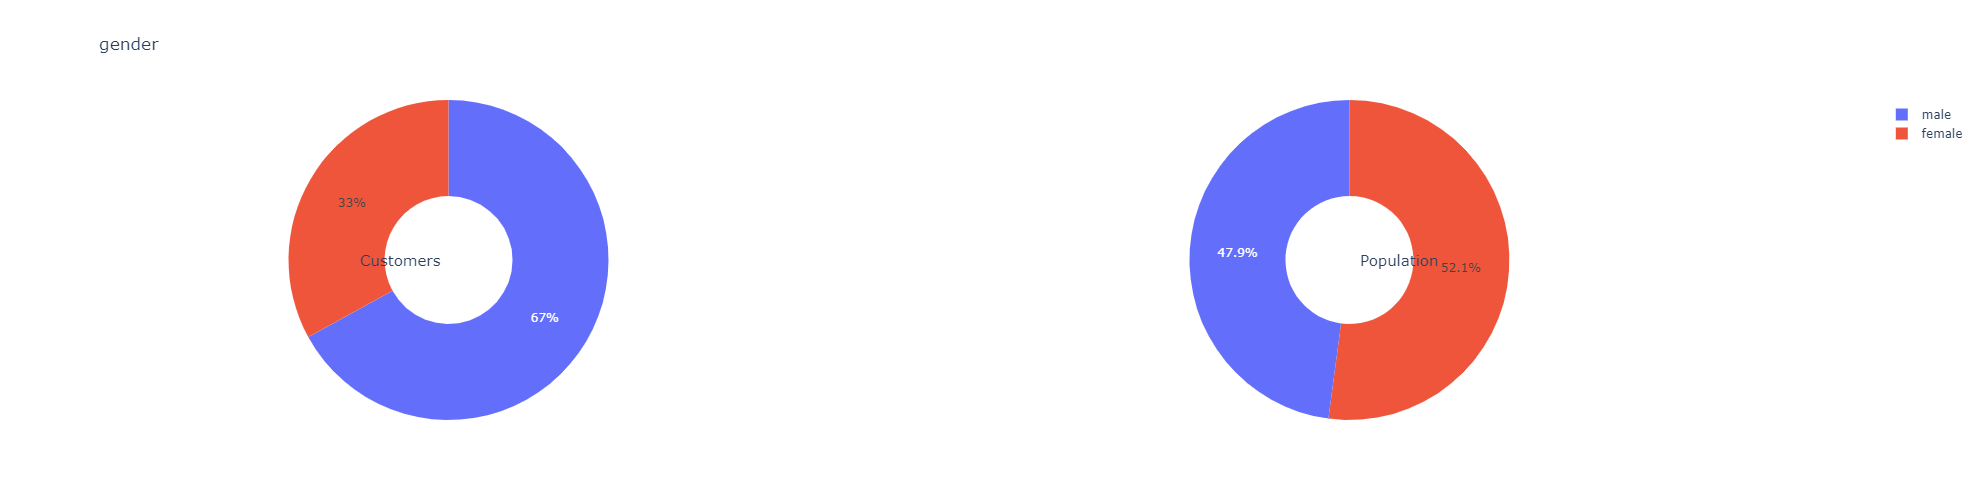

ATTRIBUTE: CJT_GESAMTTYP


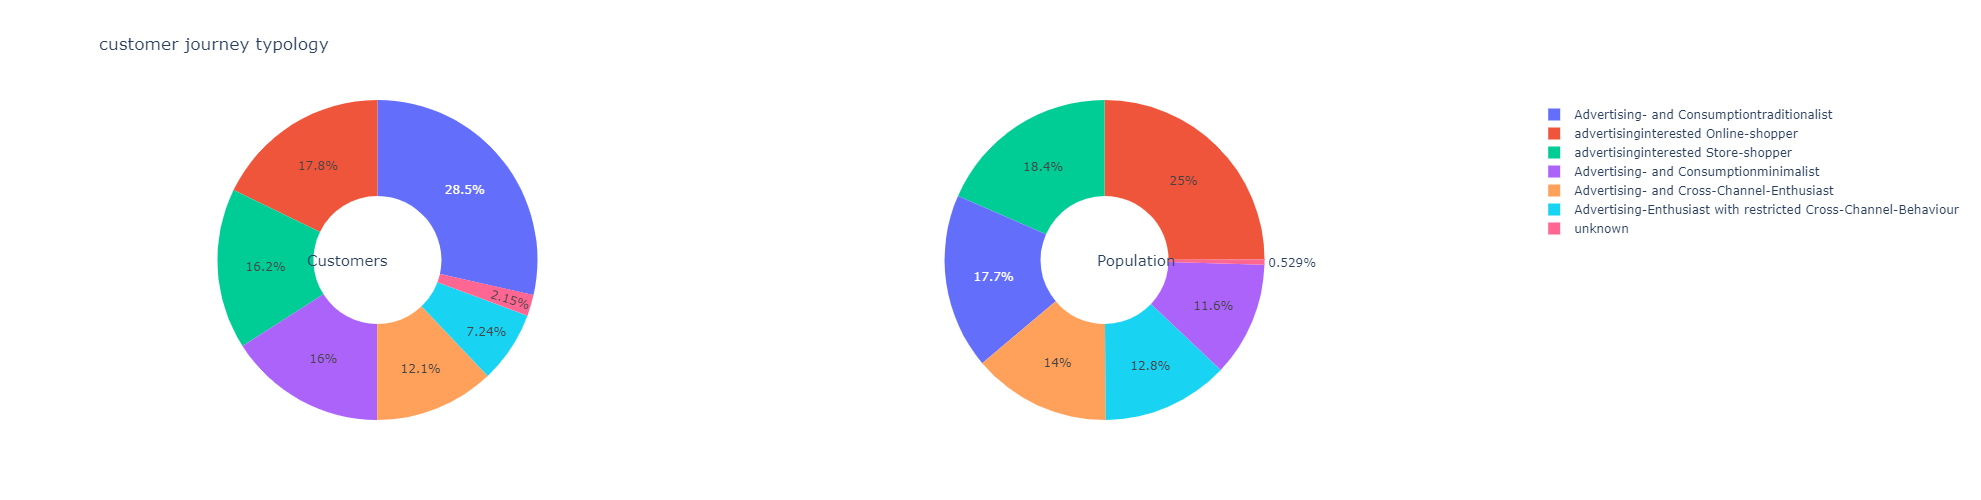

ATTRIBUTE: FINANZTYP


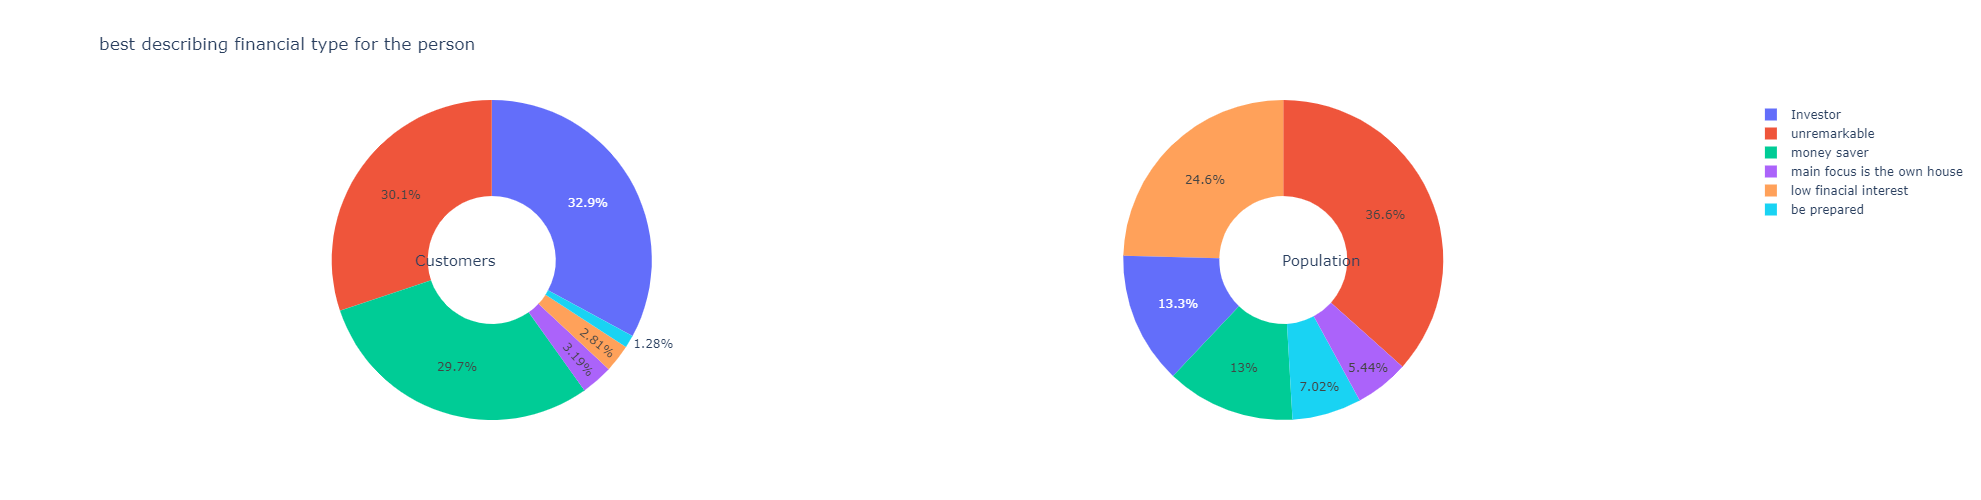

ATTRIBUTE: cat_GEBURTSJAHR


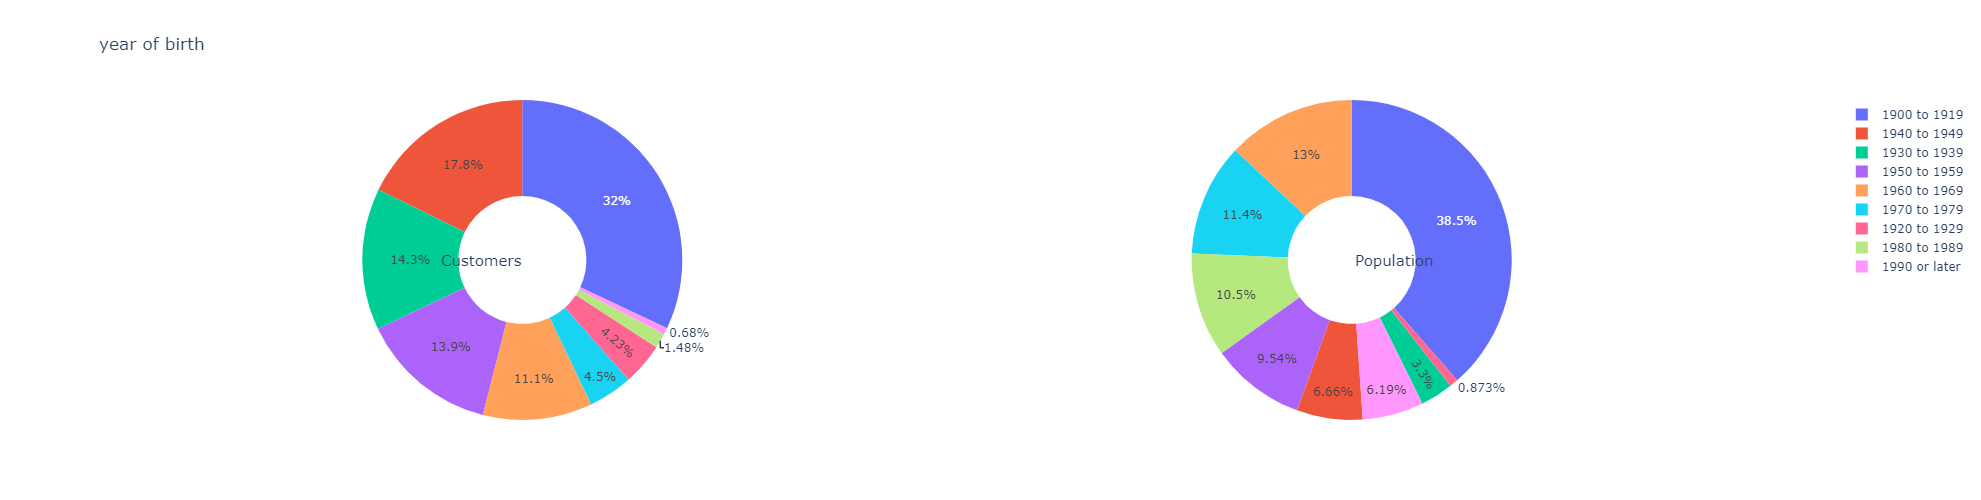

ATTRIBUTE: GFK_URLAUBERTYP


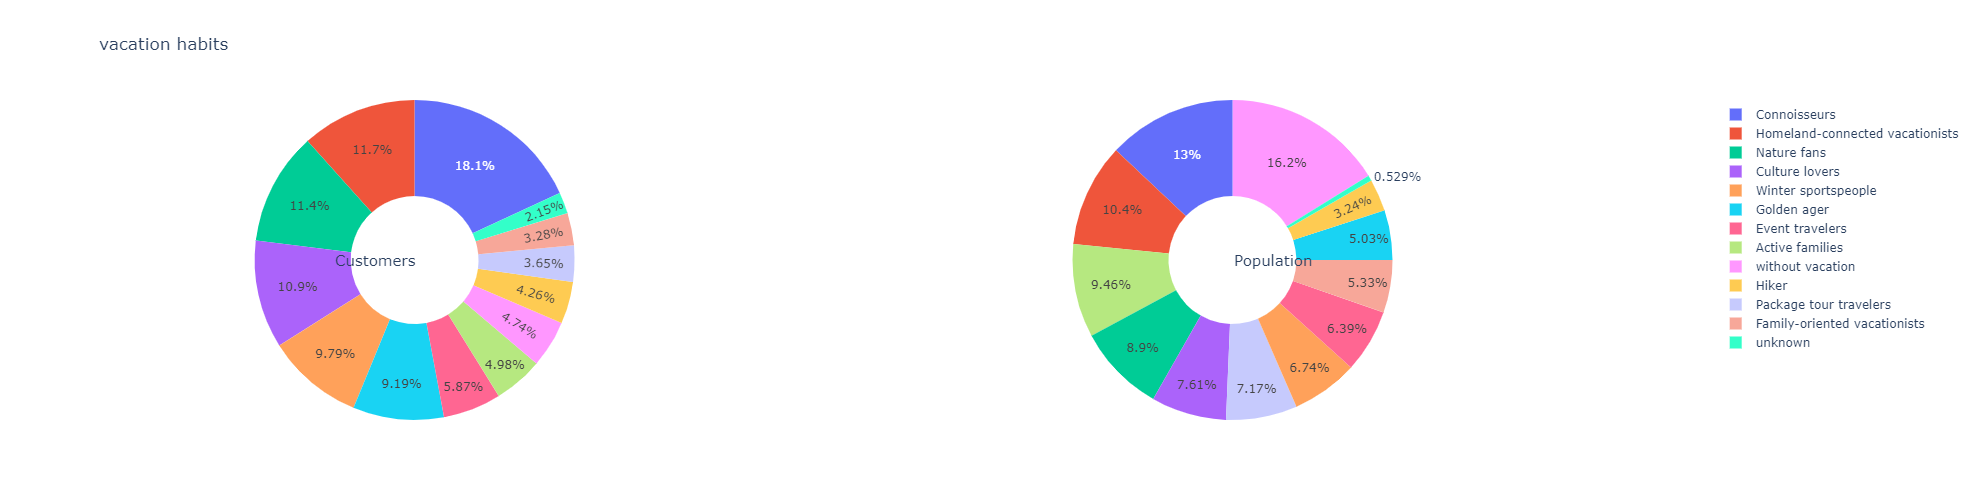

In [60]:
for attribute in attrbs_to_keep[:5]:
    print('ATTRIBUTE:',attribute)
    plot_plotly_2_pie(customers, population, attribute)


#### Perform K-Modes Clustering on Customers
K-Means is the well-known method for clustering. K-Means is appropriate for continuous variables, numeric data, but it is not appropriate for categorical data.<br>
K-Modes Clustering is the algorithm to go with for clustering using categorical data.

In [61]:
# Clustering with such a large dataframe uses too much computation. To work around this, a random sample will be taken

# create generator
rng = np.random.default_rng(0)

# select random sample without replacement
random_sample_index = rng.choice(customers.shape[0], 10000, replace=False) 

random_sample = customers.iloc[random_sample_index,][attrbs_to_keep]
# note: testing up to 5 clusters, sample of 1000 took 1 minute. sample of 10000 took 7 minutes

KModes started at 2022-03-25 19:21:31.687600
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 374941.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1709, cost: 354072.0
Run 1, iteration: 2/100, moves: 367, cost: 354072.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2455, cost: 340301.0
Run 1, iteration: 2/100, moves: 822, cost: 339906.0
Run 1, iteration: 3/100, moves: 271, cost: 339856.0
Run 1, iteration: 4/100, moves: 29, cost: 339856.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing 

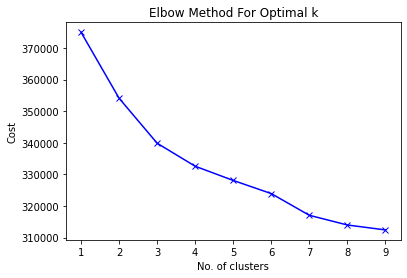

In [62]:
print('KModes started at', pd.Timestamp.now())

# Use an elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, n_init = 5, verbose=1)
    kmode.fit_predict(random_sample)
    cost.append(kmode.cost_)

print('Completed at', pd.Timestamp.now())

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()
del kmode
del random_sample

In [64]:
# 4 is the optimal number of clusters judging from the Elbow curve.
# We'll fit it again using 4 clusters and a larger sample

# select random sample without replacement
random_sample_index = rng.choice(customers.shape[0], 30000, replace=False) 

random_sample = customers.iloc[random_sample_index,][attrbs_to_keep].astype(str)

# fit KModes with 4 clusters
print('Fitting KModes, started at', pd.Timestamp.now())
kmode = KModes(n_clusters=4, n_init = 5, verbose=1)
kmode.fit(random_sample)
print('Completed at', pd.Timestamp.now())

print('Predicting KModes, started at', pd.Timestamp.now())
# predict clusters for all customer data
clusters = kmode.predict(customers[attrbs_to_keep].astype(str))
print('Completed at', pd.Timestamp.now())

del random_sample

Fitting KModes, started at 2022-03-25 19:43:01.054242
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9219, cost: 1014286.0
Run 1, iteration: 2/100, moves: 2894, cost: 1011039.0
Run 1, iteration: 3/100, moves: 2553, cost: 1009475.0
Run 1, iteration: 4/100, moves: 1482, cost: 1008654.0
Run 1, iteration: 5/100, moves: 447, cost: 1008654.0
Completed at 2022-03-25 19:47:23.557738
Predicting KModes, started at 2022-03-25 19:47:23.557738
Completed at 2022-03-25 19:49:19.550306


View the distribution of clusters for the customer base

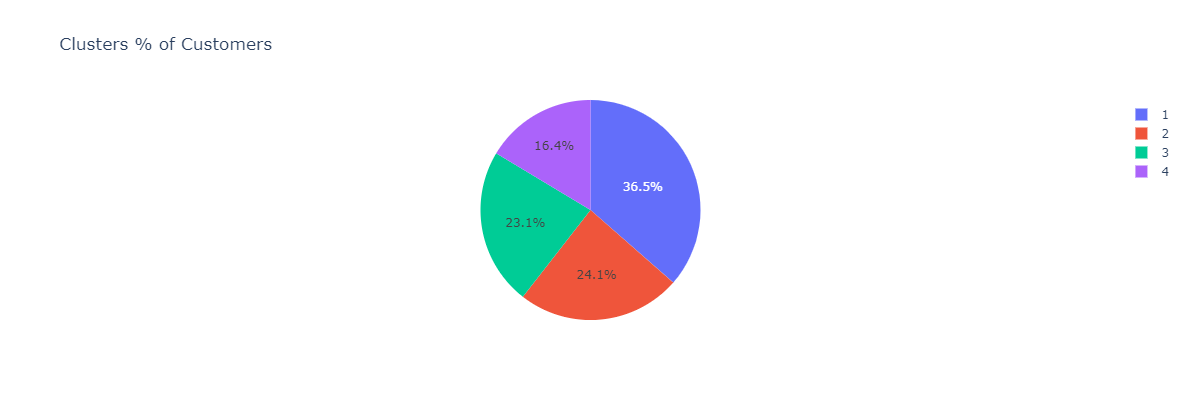

In [65]:
# Add the cluster number identifier to the main dataframe. Adding 1 so that it ranges 1 to 4
customers['cluster'] = clusters+1

# Calculate % values for the pie chart
clusters_pct_cust = np.round((customers['cluster'].value_counts()/customers.shape[0]*100).sort_index(), 1)

df_clusters_pct_cust = clusters_pct_cust.reset_index().rename({'index':'Cluster','cluster':'percent'},axis=1)
fig = go.Figure(data=[go.Pie(labels=df_clusters_pct_cust.Cluster, 
                              values=df_clusters_pct_cust['percent'], 
                              direction ='clockwise', 
                              sort=False)])
fig.update_layout(title_text='Clusters % of Customers', height=400,width=400)
fig.show()

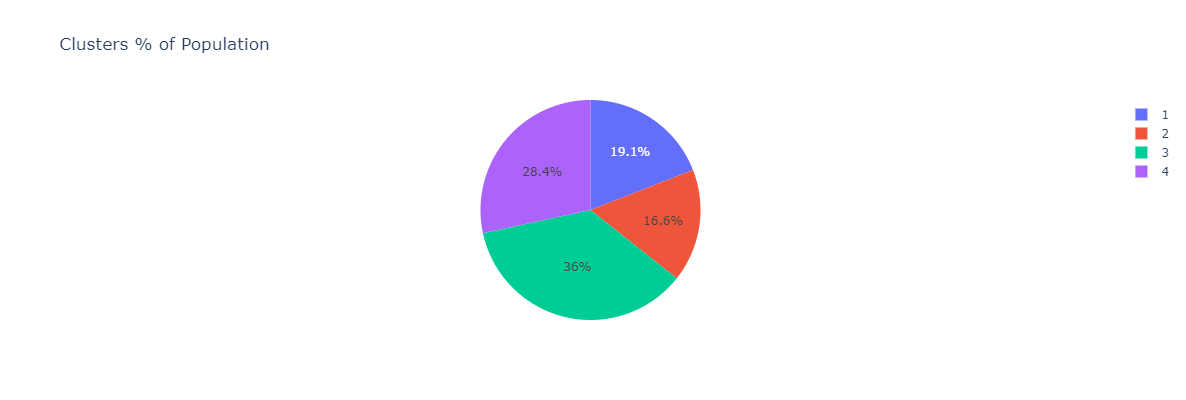

In [66]:
# Repeat with the population data to see what the distribution looks like
print('Predicting KModes, started at', pd.Timestamp.now())
clusters_pop = kmode.predict(population[attrbs_to_keep].astype(str))
print('Completed at', pd.Timestamp.now())
population['cluster'] = clusters_pop+1

clusters_pct_pop = np.round((population['cluster'].value_counts()/population.shape[0]*100).sort_index(), 1)
df_clusters_pct_pop = clusters_pct_pop.reset_index().rename({'index':'Cluster','cluster':'percent'},axis=1)
df_clusters_pct_pop['Cluster'] = df_clusters_pct_pop['Cluster'].astype(str)
fig1 = go.Figure(data=[go.Pie(labels=df_clusters_pct_pop.Cluster, 
                              values=df_clusters_pct_pop['percent'], 
                              direction ='clockwise', 
                              sort=False)])
fig1.update_layout(title_text='Clusters % of Population', height=400,width=400)
fig1.show()

Define a plotting function to use for visualising the splits of demographic attributes between the four clusters

In [68]:
def plot_plotly_4cluster_pie(data, attribute):
    """
    Shows a plot with 4 pie charts using Plotly interactive plotting
    parameters
        data: DataFrame
            contains the attributes as columns
        attribute: string
            attribute name
    """
    
    description = data_dictionary_lookup('Description', attribute=attribute, value=None, dummy=None)
    
    # Create subplots: Using 2 rows and 3 columns. Use 'domain' type for Pie subplot. 
    fig = make_subplots(rows=2, cols=4, specs=[[{'type':'domain'}, None, None, None],[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
    
    # Overall group
    vcounts = data[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    vcounts['Meaning'] = vcounts.apply(lambda row: data_dictionary_lookup('Meaning',attribute=attribute, value=row['Value'], dummy=None), axis=1)
    labels_all = vcounts['Meaning'].values
    sizes_all = vcounts['count'].values
    fig.add_trace(go.Pie(labels=labels_all, values=sizes_all, name='Customers'), 1, 1)
    
    # cluster 1
    vcounts_cluster1 = data.query(f"cluster==1")[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    vcounts_cluster1['Meaning'] = vcounts_cluster1.apply(lambda row: data_dictionary_lookup('Meaning', attribute=attribute, value=row['Value'], dummy=None), axis=1)
    labels_cluster1 = vcounts_cluster1['Meaning'].values
    sizes_cluster1 = vcounts_cluster1['count'].values    
    fig.add_trace(go.Pie(labels=labels_cluster1, values=sizes_cluster1, name=f"Cluster 1"), 2, 1)
    
    # cluster 2
    vcounts_cluster2 = data.query(f"cluster==2")[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    vcounts_cluster2['Meaning'] = vcounts_cluster2.apply(lambda row: data_dictionary_lookup('Meaning', attribute=attribute, value=row['Value'], dummy=None), axis=1)
    labels_cluster2 = vcounts_cluster2['Meaning'].values
    sizes_cluster2 = vcounts_cluster2['count'].values    
    fig.add_trace(go.Pie(labels=labels_cluster2, values=sizes_cluster2, name=f"Cluster 2"), 2, 2)
    
    # cluster 3
    vcounts_cluster3 = data.query(f"cluster==3")[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    vcounts_cluster3['Meaning'] = vcounts_cluster3.apply(lambda row: data_dictionary_lookup('Meaning', attribute=attribute, value=row['Value'], dummy=None), axis=1)
    labels_cluster3 = vcounts_cluster3['Meaning'].values
    sizes_cluster3 = vcounts_cluster3['count'].values    
    fig.add_trace(go.Pie(labels=labels_cluster3, values=sizes_cluster3, name=f"Cluster 3"), 2, 3)
    
    # cluster 4
    vcounts_cluster4 = data.query(f"cluster==4")[attribute].value_counts().reset_index().rename({'index':'Value', attribute:'count'},axis=1)
    vcounts_cluster4['Meaning'] = vcounts_cluster4.apply(lambda row: data_dictionary_lookup('Meaning', attribute=attribute, value=row['Value'], dummy=None), axis=1)
    labels_cluster4 = vcounts_cluster4['Meaning'].values
    sizes_cluster4 = vcounts_cluster4['count'].values    
    fig.add_trace(go.Pie(labels=labels_cluster4, values=sizes_cluster4, name=f"Cluster 4"), 2, 4)
    
    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")  
    
    annotations = [dict(text='Customers', x = 0.071, y=0.81, font_size=15, showarrow=False),
                   dict(text='Cluster 1', x = 0.077, y=0.193, font_size=15, showarrow=False),
                   dict(text='Cluster 2', x = 0.369, y=0.193, font_size=15, showarrow=False),
                   dict(text='Cluster 3', x = 0.631, y=0.193, font_size=15, showarrow=False),
                   dict(text='Cluster 4', x = 0.922, y=0.193, font_size=15, showarrow=False),
                  ]
    
    fig.update_layout(
        title_text=description,
        # Add annotations in the center of the donut pies.
        annotations=annotations,
        height=700,
        width=1400,
        legend=dict(
            yanchor="top",
            y=1,
            xanchor="right",
            x=1)
    )
    
    fig.show()

Next, we'll use the plotting function to view the demographics of the customer segments

ATTRIBUTE: ANREDE_KZ


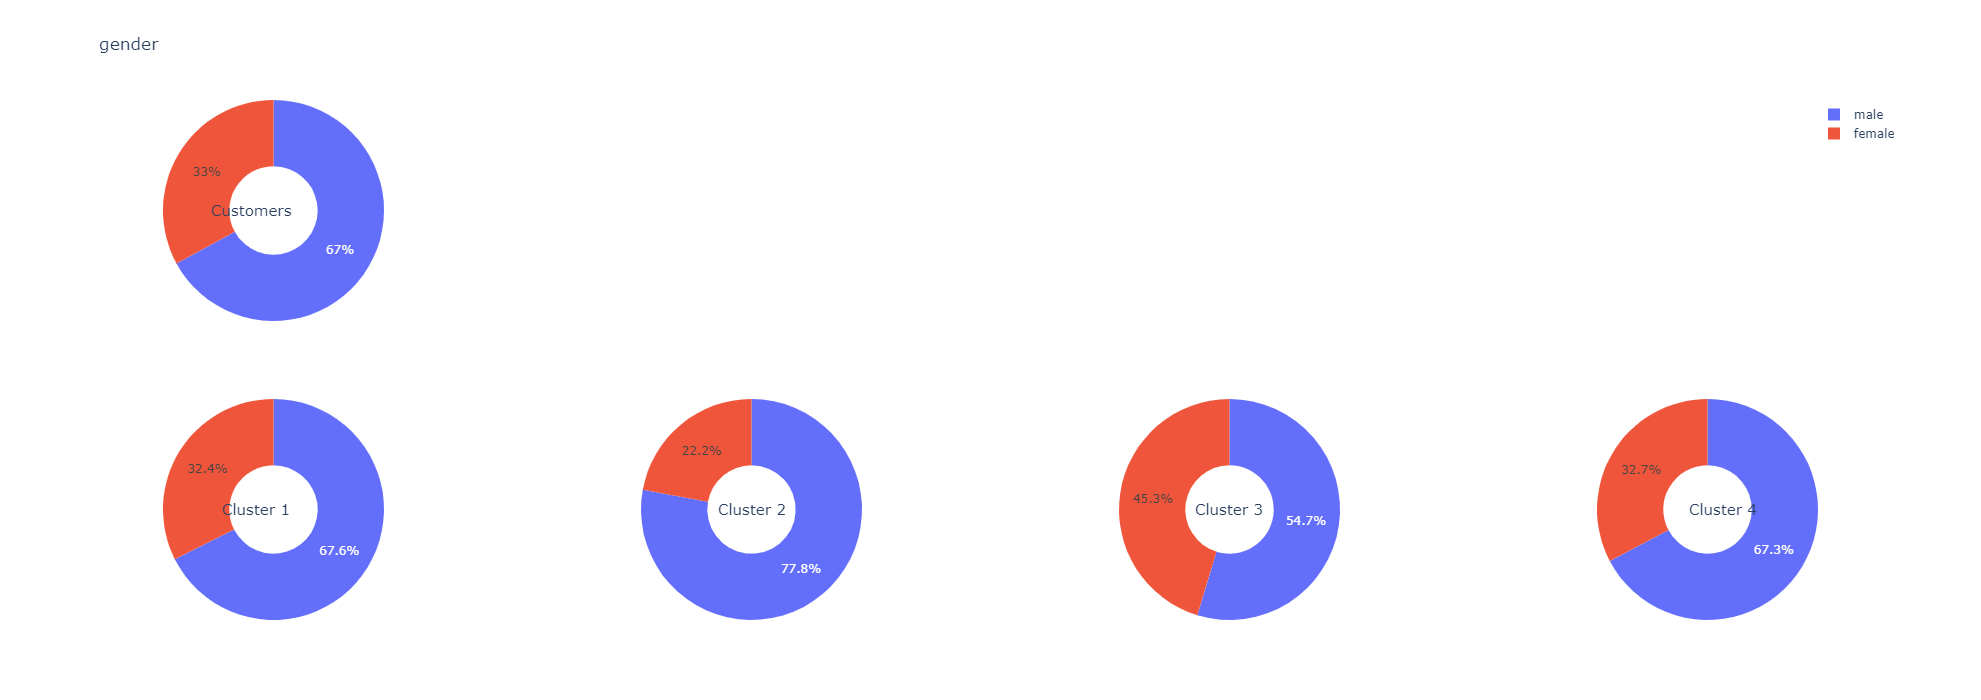

ATTRIBUTE: CJT_GESAMTTYP


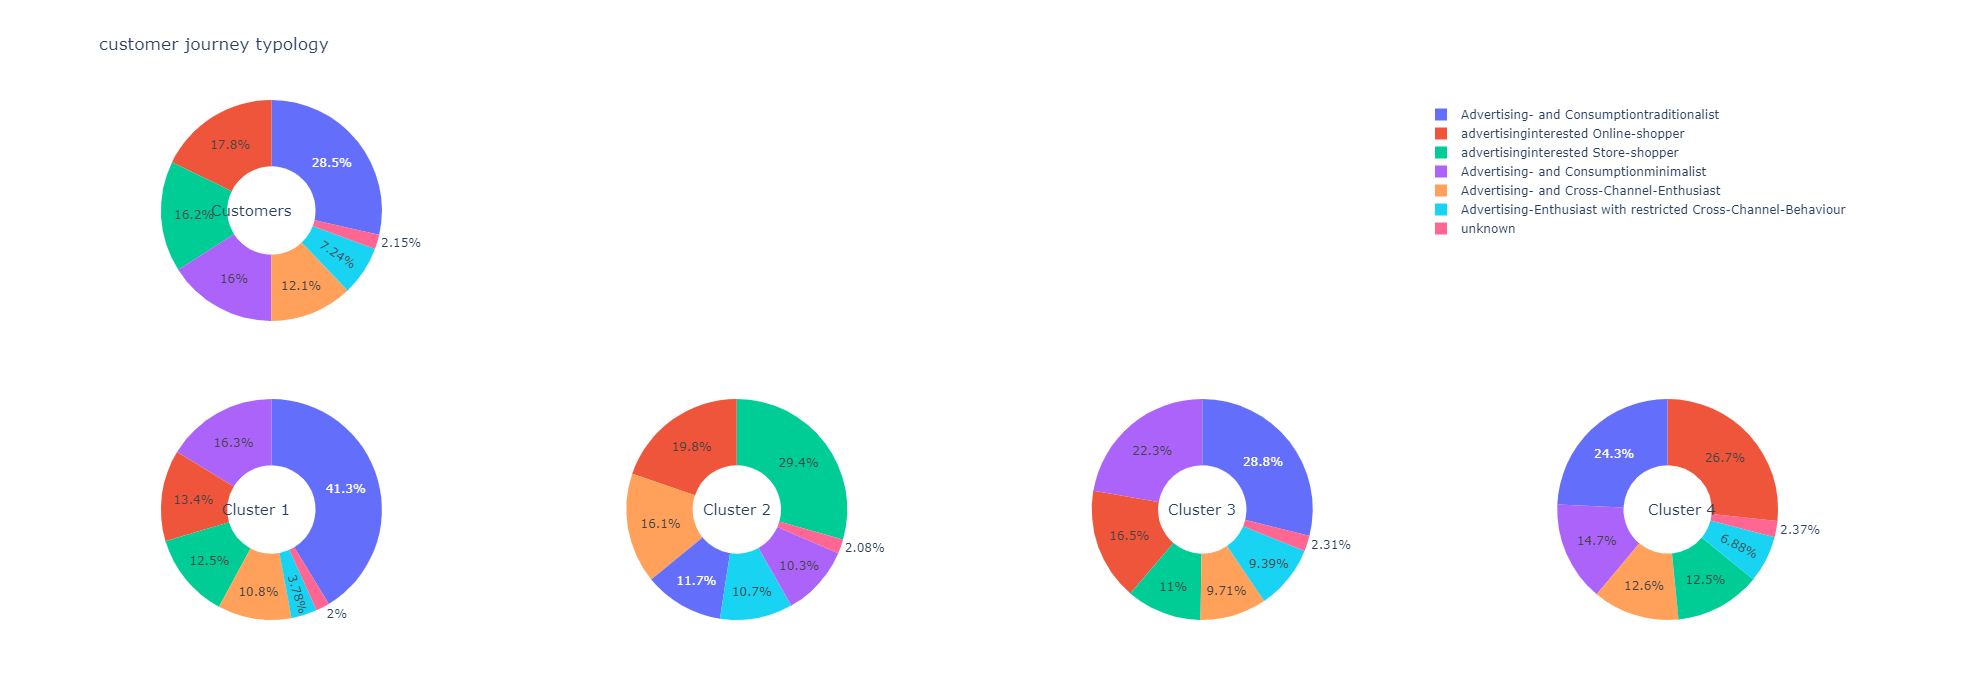

ATTRIBUTE: FINANZTYP


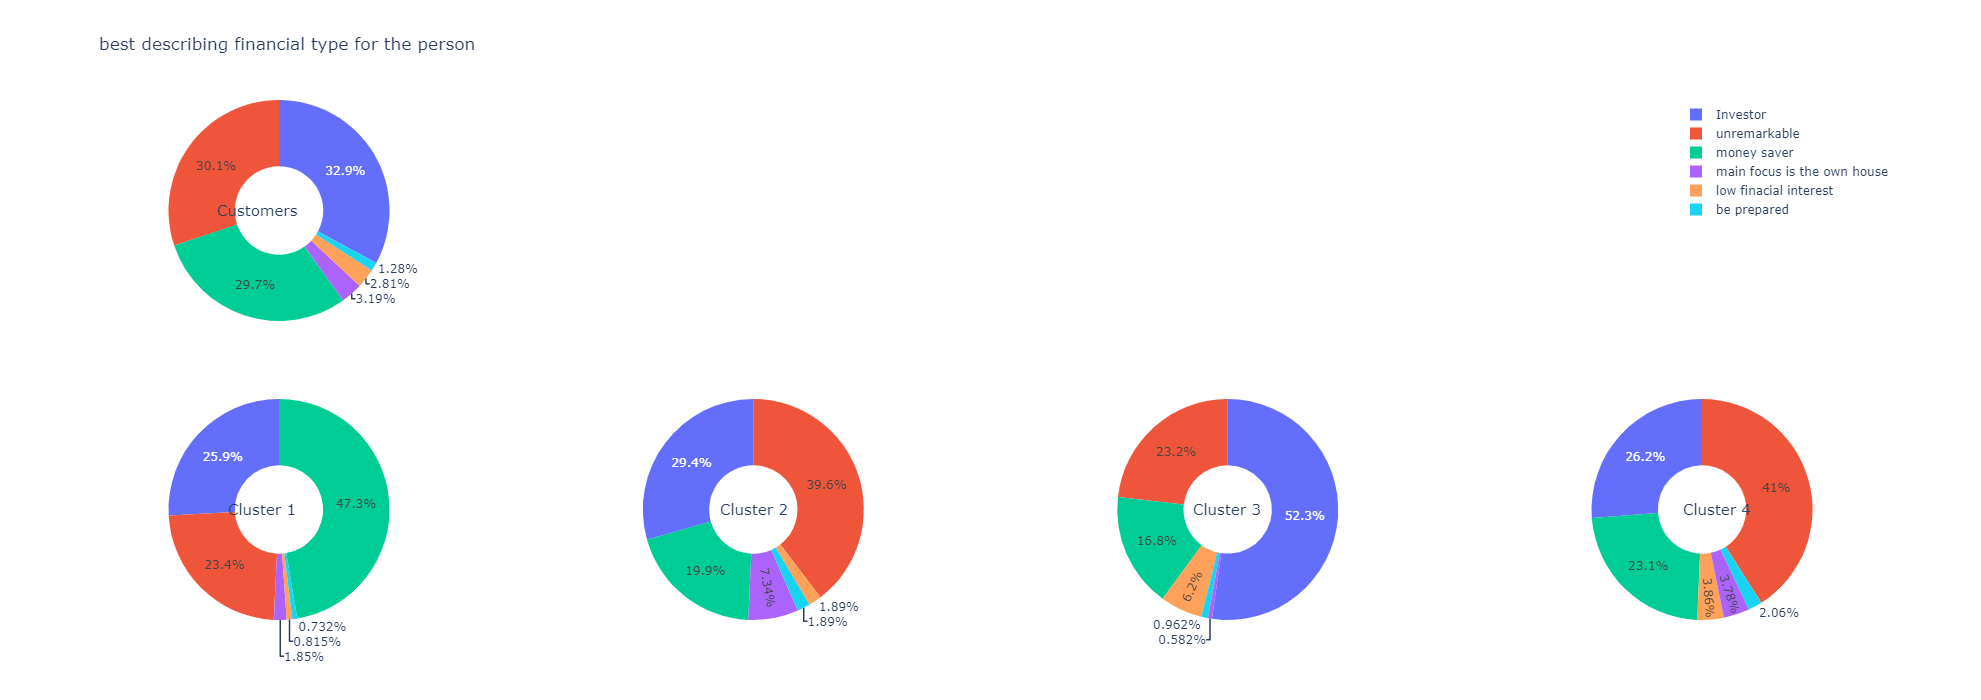

ATTRIBUTE: cat_GEBURTSJAHR


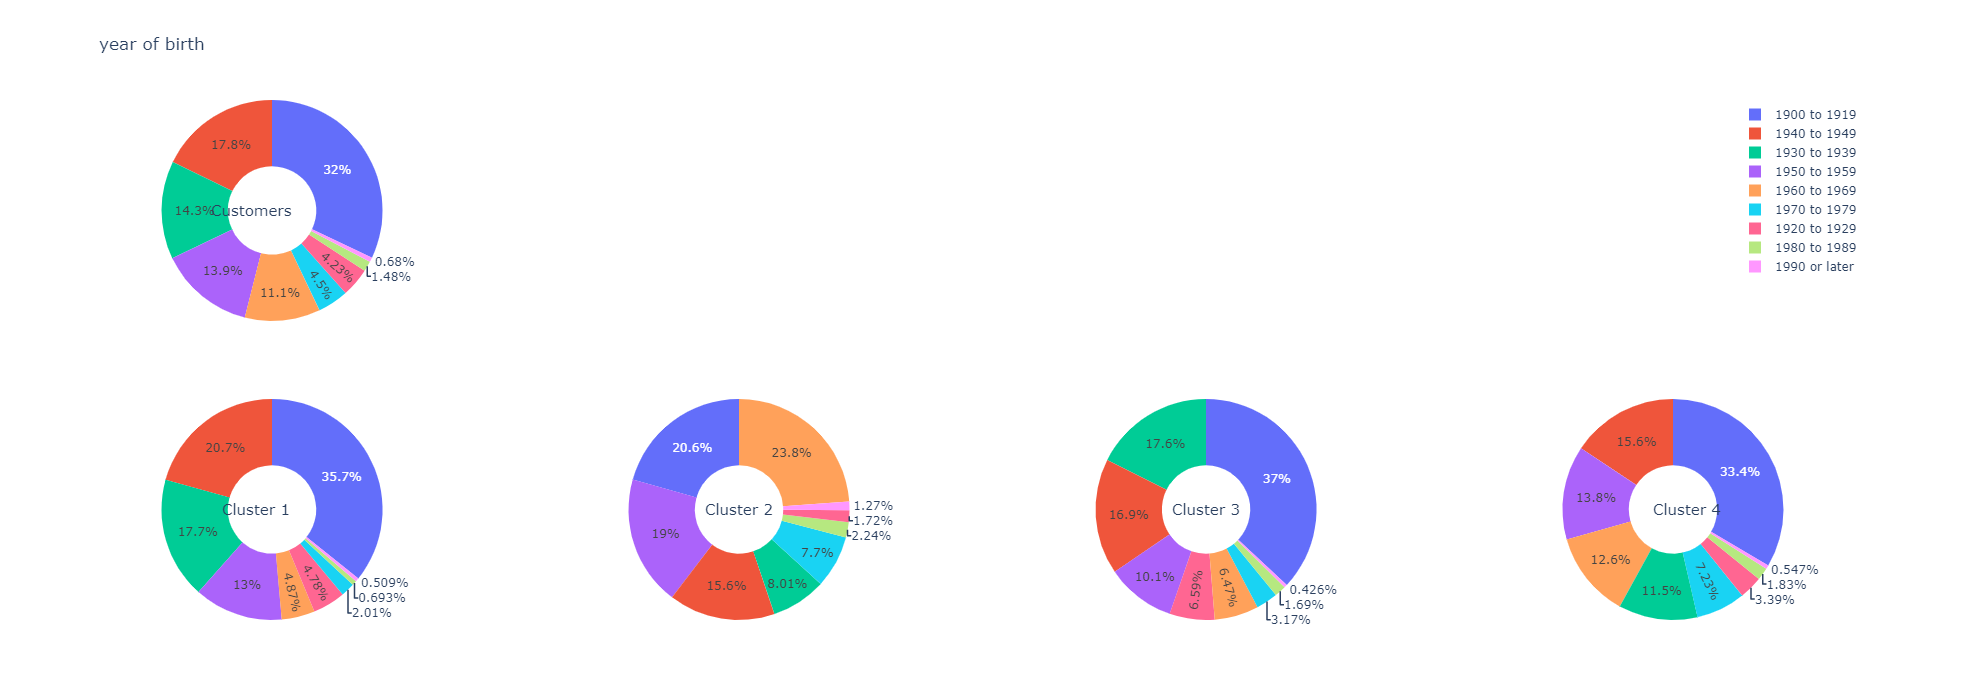

ATTRIBUTE: GFK_URLAUBERTYP


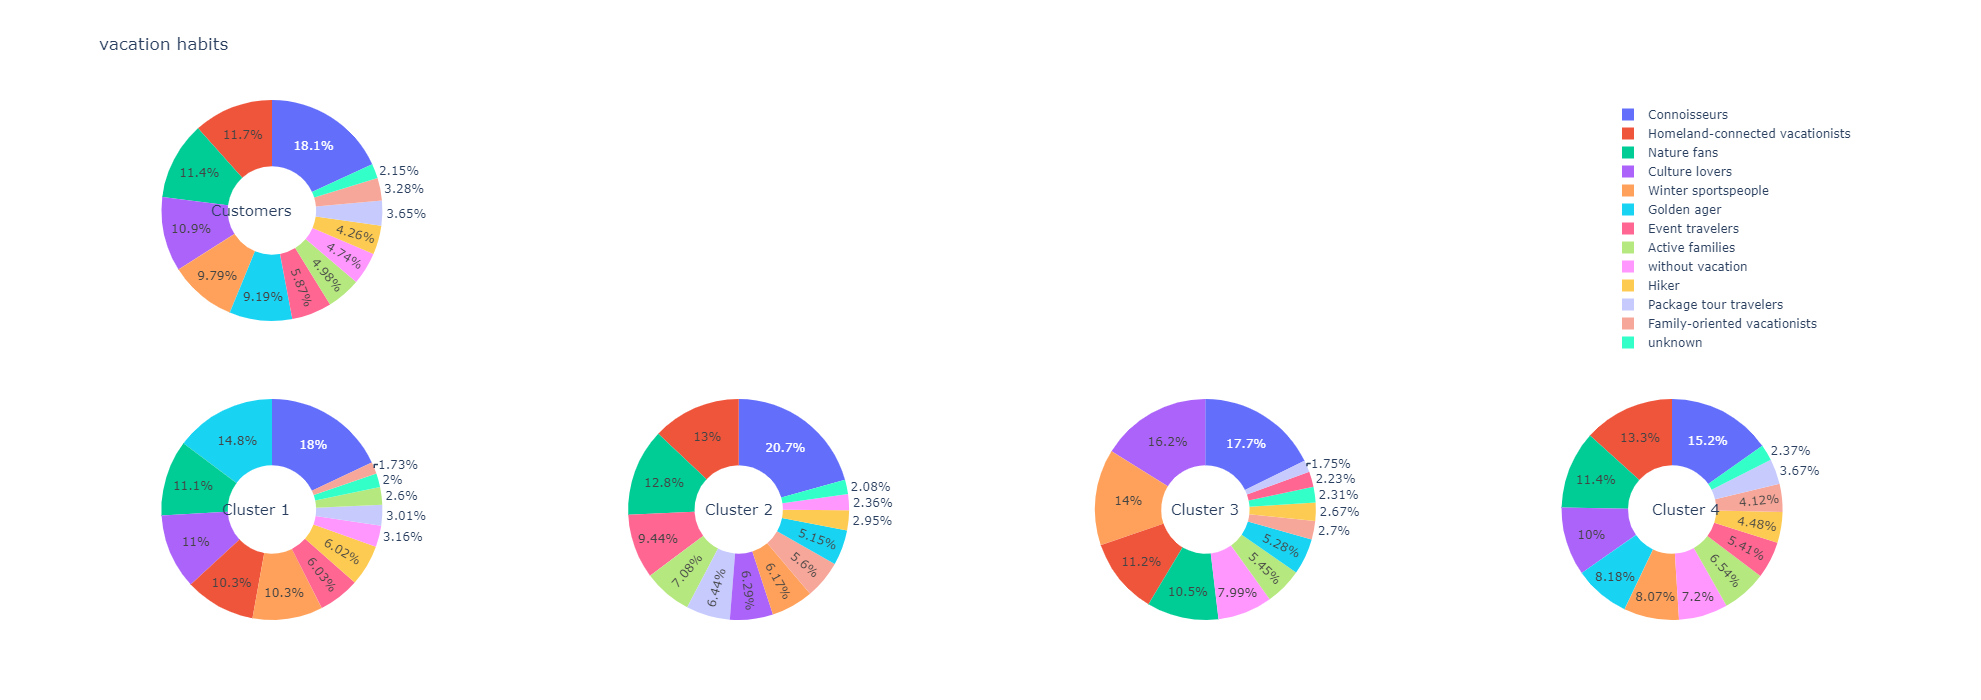

In [70]:
for attribute in attrbs_to_keep[:5]:
    print('ATTRIBUTE:',attribute)
    plot_plotly_4cluster_pie(customers, attribute)

### Create a dataset containing population and customer data combined then run the K-Modes clustering algorithm
Given that the age groups 1980s-1989 and 1990+ are almost non-existent in the customer base, it will make the analysis more substantive to remove this data and treat it as a cluster in its own.

In [71]:
encoded_data_dictionary.query('Attribute=="cat_GEBURTSJAHR"').head(10) # so we're after values below 7

,Attribute,Description,Value,Meaning
0,cat_GEBURTSJAHR,year of birth,-1,unknown
1,cat_GEBURTSJAHR,year of birth,0,1900 to 1919
2,cat_GEBURTSJAHR,year of birth,1,1920 to 1929
3,cat_GEBURTSJAHR,year of birth,2,1930 to 1939
4,cat_GEBURTSJAHR,year of birth,3,1940 to 1949
5,cat_GEBURTSJAHR,year of birth,4,1950 to 1959
6,cat_GEBURTSJAHR,year of birth,5,1960 to 1969
7,cat_GEBURTSJAHR,year of birth,6,1970 to 1979
8,cat_GEBURTSJAHR,year of birth,7,1980 to 1989
9,cat_GEBURTSJAHR,year of birth,8,1990 or later


In [72]:
# adding a label for identifying customers
customers['customer'] = True
population['customer'] = False

# combine the dataframes with the young age groups filtered out
cust_pop_combined = pd.concat([customers.query("cat_GEBURTSJAHR<7")[attrbs_to_keep+['customer']],population.query("cat_GEBURTSJAHR<7")[attrbs_to_keep+['customer']]])

print('customer df shape',customers.shape)
print('population df shape',population.shape)
print('customer % of new df:', np.round(customers.shape[0]/(customers.shape[0]+population.shape[0])*100,2))
print('---- After removing the two youngest age groups:----')
print('customer df shape',customers.query("cat_GEBURTSJAHR<7").shape)
print('population df shape',population.query("cat_GEBURTSJAHR<7").shape)
print('customer % of new df:', np.round(customers.query("cat_GEBURTSJAHR<7").shape[0]/cust_pop_combined.shape[0]*100,2))

customer df shape (141586, 69)
population df shape (786207, 66)
customer % of new df: 15.26
---- After removing the two youngest age groups:----
customer df shape (138524, 69)
population df shape (654601, 66)
customer % of new df: 17.47


In [37]:
# Clustering with such a large dataframe uses too much computation. To work around this, a random sample will be taken
# create generator
rng = np.random.default_rng(0)

# select random sample without replacement
random_sample_index = rng.choice(cust_pop_combined.shape[0], 10000, replace=False) 
random_sample = cust_pop_combined.iloc[random_sample_index,][attrbs_to_keep] # we won't keep the customer identifier in

KModes started at 2022-03-25 20:09:20.483516
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 394250.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1629, cost: 372597.0
Run 1, iteration: 2/100, moves: 532, cost: 372381.0
Run 1, iteration: 3/100, moves: 38, cost: 372381.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2744, cost: 360324.0
Run 1, iteration: 2/100, moves: 851, cost: 360007.0
Run 1, iteration: 3/100, moves: 77, cost: 360007.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing c

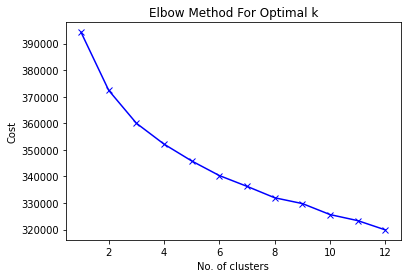

In [74]:
print('KModes started at', pd.Timestamp.now())

# Use an elbow curve to find optimal K
cost = []
K = range(1,13)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, n_init = 5, verbose=1)
    kmode.fit_predict(random_sample)
    cost.append(kmode.cost_)

print('Completed at', pd.Timestamp.now())

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()
del kmode
del random_sample

In [38]:
# 8 is good number of clusters judging from the Elbow curve. Now fit it with a larger sample and 8 clusters

# select random sample without replacement
random_sample_index = rng.choice(customers.shape[0], 30000, replace=False) 

random_sample = customers.iloc[random_sample_index,][attrbs_to_keep].astype(str)

# fit KModes with 8 clusters
print('Fitting KModes with 8 clusters, started at', pd.Timestamp.now())
kmode8 = KModes(n_clusters=8, n_init = 5, verbose=1)
kmode8.fit(random_sample)
print('Completed at', pd.Timestamp.now())
del random_sample

Fitting KModes with 8 clusters, started at 2022-03-30 20:00:51.749083
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11537, cost: 954248.0
Run 1, iteration: 2/100, moves: 3576, cost: 953598.0
Run 1, iteration: 3/100, moves: 880, cost: 952581.0
Run 1, iteration: 4/100, moves: 765, cost: 952581.0
Completed at 2022-03-30 20:07:42.367539


In [77]:
print('Predicting for KModes with 8 clusters, started at', pd.Timestamp.now())
# predict clusters for all customer data using the 8 cluster model
cust_pop_combined['cluster_8'] = kmode8.predict(cust_pop_combined[attrbs_to_keep].astype(str)) + 1
print('Completed at', pd.Timestamp.now())

Predicting for KModes with 8 clusters, started at 2022-03-25 21:09:40.548976
Completed at 2022-03-25 21:29:23.501411


In [83]:
# Add back the group of younger folks who were removed and label them cluster 0
print('Adding back younger groups and labelling cluster 0, started at', pd.Timestamp.now())
younger_customers = customers.query("cat_GEBURTSJAHR>6")[attrbs_to_keep+['customer']]
younger_population = population.query("cat_GEBURTSJAHR>6")[attrbs_to_keep+['customer']]

younger_customers['cluster_8'] = 0
younger_population['cluster_8'] = 0

cust_pop_combined = pd.concat([cust_pop_combined,younger_customers,younger_population])
del younger_customers, younger_population
print('Completed at', pd.Timestamp.now())

Adding back younger groups and labelling cluster 0, started at 2022-03-25 21:34:12.808128
Completed at 2022-03-25 21:34:13.232689


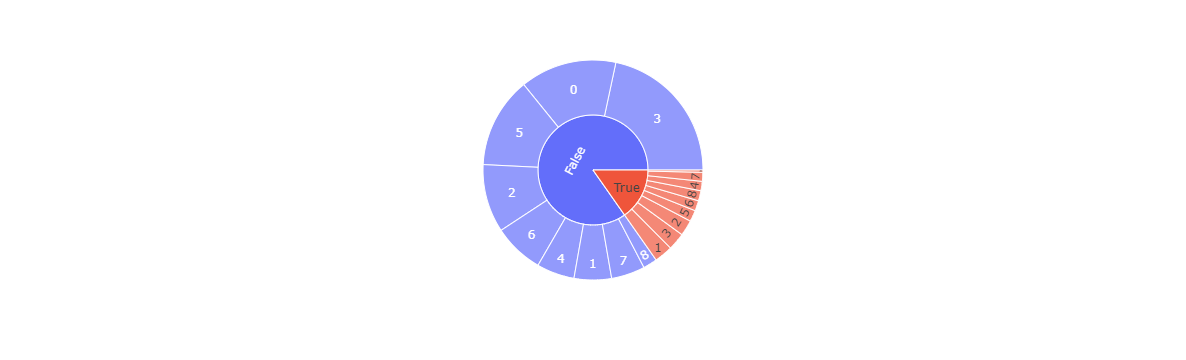

In [86]:
# look at the 8 cluster distribution using a sunburst plot
clusters_pct = np.round(cust_pop_combined.groupby(['cluster_8','customer']).size()/cust_pop_combined.shape[0]*100,2).reset_index().rename({0:'% distribution'},axis=1)
fig = px.sunburst(clusters_pct, path=['customer', 'cluster_8'], values='% distribution')
fig.show()

#### See the effectiveness of the clustering for identifying groups who are more responsive to marketing campaigns
Might focusing marketing efforts on certain clusters improve response rates?

In [39]:
# separate the younger group who we chose to exist as a separate cluster
train_older = train.query("cat_GEBURTSJAHR<7")
print('Predicting for KModes with 8 clusters, started at', pd.Timestamp.now())
train_older['cluster_8'] = kmode8.predict(train_older[attrbs_to_keep].astype(str)) + 1

train_younger = train.query("cat_GEBURTSJAHR>6")
train_younger['cluster_8'] = 0

train_clustered = pd.concat([train_older, train_younger])
print('Completed at', pd.Timestamp.now())

Predicting for KModes with 8 clusters, started at 2022-03-30 20:07:42.434471
Completed at 2022-03-30 20:08:33.978613


<ipython-input-39-cd8f3d54d514>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_older['cluster_8'] = kmode8.predict(train_older[attrbs_to_keep].astype(str)) + 1
<ipython-input-39-cd8f3d54d514>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_younger['cluster_8'] = 0


In [342]:
print('There were',sum(train_clustered['RESPONSE']), 'responses overall', 'out of',train_clustered.shape[0], 'mail outs')
print('This makes a response rate of',100*sum(train_clustered['RESPONSE'])/train_clustered.shape[0], 'percent')

There were 438 responses overall out of 35176 mail outs
This makes a response rate of 1.245167159426882 percent


In [99]:
# See response rates by cluster
train_8cluster_response = train_clustered.groupby('cluster_8')['RESPONSE'].sum()/train_clustered.groupby('cluster_8')['RESPONSE'].size()*100
print(train_8cluster_response.head(10))

cluster_8
0    0.663717
1    1.358470
2    0.885987
3    1.314260
4    1.251564
5    1.009017
6    1.235343
7    1.638689
8    1.870851
Name: RESPONSE, dtype: float64


This reveals that a far higher response rate can be achievd by targetting the clusters 1, 3, 7 and 8.

## Part 2: Supervised Learning Model
Now that we've found which parts of the population are more likely to become customers of the mail-order company, it's time to build a prediction model. Each of the rows in the training data represents an individual that was targeted for a mailout campaign.<br>
Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.<br>
Note that part 2 uses the output of the clustering performed in part 1 so ensure part 1 is run.

In [40]:
print('There were',sum(train_clustered['RESPONSE']), 'responses overall', 'out of',train_clustered.shape[0], 'mail outs')
print('This makes a response rate of',100*sum(train_clustered['RESPONSE'])/train_clustered.shape[0], 'percent')
# This makes the class very small to try and predict. The model should have the class weighted to accommodate this.

There were 438 responses overall out of 35176 mail outs
This makes a response rate of 1.245167159426882 percent


In [197]:
# get a reminder of attributes available to hand pick some. Choosing too many results in 0 predictions as the decision tree has too much to choose from.
for attribute in attrbs_to_keep:
    print(attribute, data_dictionary_lookup('Description', attribute=attribute, value=None, dummy=None))

ANREDE_KZ gender
CJT_GESAMTTYP customer journey typology
FINANZTYP best describing financial type for the person
cat_GEBURTSJAHR year of birth
GFK_URLAUBERTYP vacation habits
GREEN_AVANTGARDE Green avantgarde
LP_LEBENSPHASE_FEIN lifestage fine 
LP_FAMILIE_FEIN familytyp fine
LP_STATUS_FEIN social status fine
NATIONALITAET_KZ nationaltity (scored by prename analysis)
RETOURTYP_BK_S return type
SEMIO_SOZ affinity indicating in what way the person is social minded
SEMIO_FAM affinity indicating in what way the person is familiar minded
SEMIO_REL affinity indicating in what way the person is religious
SEMIO_MAT affinity indicating in what way the person is material minded
SEMIO_LUST affinity indicating in what way the person is sensual minded
SEMIO_ERL affinity indicating in what way the person is eventful orientated
SEMIO_RAT affinity indicating in what way the person is of a rational mind
SEMIO_KRIT affinity indicating in what way the person is critical minded
SEMIO_DOM affinity indicatin

In [82]:
# choose a smaller selection of features to use. 
# If too many are used, 0 predictions get made since there is too much to choose from
cols_to_use = ['cat_GEBURTSJAHR','ONLINE_AFFINITAET','HH_EINKOMMEN_SCORE',
               'ORTSGR_KLS9','cat_ANZ_PERSONEN','RELAT_AB','LP_LEBENSPHASE_FEIN','cluster_8']

# select the data of interest for X and y variables
X = train_clustered.reset_index().drop(columns=['index','RESPONSE'])[cols_to_use]
y = train_clustered['RESPONSE'].values

# construct a pipeline with a random forest classifier model
random_forest = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    # make sure a balanced class weight is used since the target is really unbalanced with only 1.25% responses.
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0, class_weight = "balanced")
)

# view the cross-validated scores
scores_random_forest = cross_val_score(random_forest, X, y, cv=3, scoring='precision')

print(f"Random forest classifier: "
      f"{scores_random_forest.mean():.3f} +/- "
      f"{scores_random_forest.std():.3f}")
print('variable descriptions:',
      [data_dictionary_lookup('Description', attribute=attrb) if attrb != 'cluster_8' else 'cluster_8'\
       for attrb in cols_to_use], sep ='\n')

Random forest classifier: 0.022 +/- 0.016
variable descriptions:
['year of birth', 'online affinity', 'estimated household net income ', 'size of the community', 'number of persons known in this household', 'share of unemployed in relation to the county the community belongs to', 'lifestage fine ', 'cluster_8']


Including the 'cluster_8' feature boosts precision from 0.014 to 0.022.<br>
This is a slight improvement over simply mailing out to all in certain clusters and a good improvement over the option of mailing to all (response rate 0.012)<br>
See what the importances are of the features used in the model

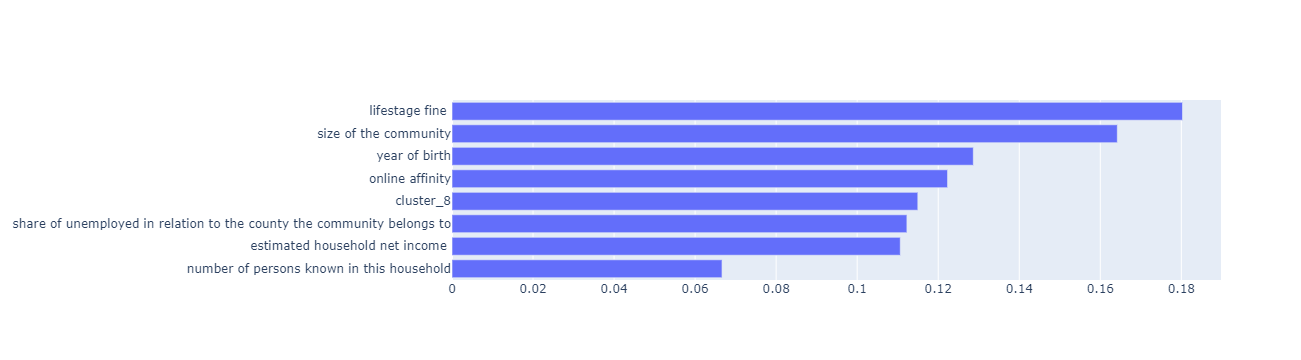

In [77]:
# fit the random forest classifier using the chosen features and get the feature importances
clf = RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0, class_weight = "balanced")
clf.fit(X, y)
feat_imps = clf.feature_importances_

# compose a horizontal bar chart
fig = go.Figure(go.Bar(
            x=feat_imps,
            y=[data_dictionary_lookup('Description', attribute=attrb) if attrb != 'cluster_8' else 'cluster_8' for attrb in cols_to_use],
            orientation='h'))

# order in ascending order
fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()